In [1]:
#한글지원용

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    cleaned_corpus = list(set(zip(kor, eng)))
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [4]:
cleaned_corpus[0]

('Australian naturalist killed호주인 자연 탐험가 사망2006.11 원문 & 독해설명 인쇄',
 'Australian naturalist and television personality Steve Irwin has been killed by a stingray during a diving expedition off the Australian coast.')

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)

    sentence = sentence.strip()
    return sentence

In [6]:
import sentencepiece as spm
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    temp_file = os.getenv('HOME') + f'/aiffel/transformer/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0],pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/corpus_ko.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/corpus_ko.txt
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  

True

In [7]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)
    # [[YOUR CODE]]

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [8]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [10]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [12]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [15]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [16]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [17]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [19]:
transformer = Transformer(n_layers=4, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff = 2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=50, 
                          dropout=0.4, 
                          shared=True)

In [20]:
# train step
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [21]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [22]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [23]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [24]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 30

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_912/58388524.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a good .
Input: 시민들은 도시 속에 산다.
Predicted translation: the area is now .
Input: 커피는 필요 없다.
Predicted translation: it is not going to be a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a greater .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is a small town of  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: it s not a little bit .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the illinois presidential nominee is the first african american .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee must be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll in the death toll .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is currently the world .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is part of the city .
Input: 커피는 필요 없다.
Predicted translation: it s not necessary to eat .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the blast .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president elect is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the cities of the city .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died in the blast .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first thing .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s cities is far in cities .
Input: 커피는 필요 없다.
Predicted translation: don t need to be asked to be asked to be asked to be asked to be needd to be needn .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed in the blast .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city center beach townsfolk mayor palin s urban areas .
Input: 커피는 필요 없다.
Predicted translation: coffee is never required .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven miners have died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s clean air sector
Input: 커피는 필요 없다.
Predicted translation: don t need to be stopped developing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven live deadly in seven other people s dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city mayor th trails in the city .
Input: 커피는 필요 없다.
Predicted translation: if special needs to get to need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh dead was not injured .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are driven in the water .
Input: 커피는 필요 없다.
Predicted translation: don t need to ask if you don t need to need to need to need to need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh fatality was the deadly wed to the mother of seven people .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: this is just gone from the blagojevich .
Input: 커피는 필요 없다.
Predicted translation: don t need to ask for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the works .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in cities to rely on the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is never called coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city truman is in the city .
Input: 커피는 필요 없다.
Predicted translation: don t need to plan
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths died from nbc .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only way to pick mccain .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is watching the air .
Input: 커피는 필요 없다.
Predicted translation: don t need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deadly blasts .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest twist .
Input: 시민들은 도시 속에 산다.
Predicted translation: this is cities in cities where .
Input: 커피는 필요 없다.
Predicted translation: don t need to learn that .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the blast .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is seeking ways to draw tear down the presidential nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is watching the city s civilization .
Input: 커피는 필요 없다.
Predicted translation: don t need to be prices .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven year old seven story apartments were found dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is only a economic recovery .
Input: 시민들은 도시 속에 산다.
Predicted translation: city protests are situations in the cities .
Input: 커피는 필요 없다.
Predicted translation: don t need to be called anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven year old no other was found , but was killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest supporter of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city protests have been around in the background .
Input: 커피는 필요 없다.
Predicted translation: don t need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh person killed in the blast .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a chance to draw attention to president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city green was also home to some for many .
Input: 커피는 필요 없다.
Predicted translation: don t need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed orth .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a criminal investigation for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: this city was in the city .
Input: 커피는 필요 없다.
Predicted translation: need to mercury .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh fatalities come through the sprawling wreckage . seven other people were killed or seven others iraqis .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest country without the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city rivals others in the background .
Input: 커피는 필요 없다.
Predicted translation: coffee is never required .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh died in seven .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city opponents hospital in the water .
Input: 커피는 필요 없다.
Predicted translation: don t need to worry
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people live in the blast .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a crowd .
Input: 시민들은 도시 속에 산다.
Predicted translation: city opponents in question the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is never threatened , bed said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh fatality was wrote .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a man . he is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: watch cities in the cities of ten towns in myanmar .
Input: 커피는 필요 없다.
Predicted translation: don t need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the reality alone .
Input: 시민들은 도시 속에 산다.
Predicted translation: city opponents mayors in the city .
Input: 커피는 필요 없다.
Predicted translation: if don t need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven reports raised no deaths in the russian parliament .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: this is just in cities where consumers drives in the city .
Input: 커피는 필요 없다.
Predicted translation: don t need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven missing personnel were killed in the blast .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: this city draws in the water .
Input: 커피는 필요 없다.
Predicted translation: don t need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven other dead were caught .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the necessary person .
Input: 시민들은 도시 속에 산다.
Predicted translation: this is in myanmar city .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to industry .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the place in iraq .
Input: 시민들은 도시 속에 산다.
Predicted translation: city opponents want to see the city slight .
Input: 커피는 필요 없다.
Predicted translation: if you don t need a price , needed smart job
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the works .
Input: 시민들은 도시 속에 산다.
Predicted translation: green is in the water .
Input: 커피는 필요 없다.
Predicted translation: don t need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were missing in the blast .


Input: 오늘꺼는 그래도 변역기 흉내는 내네
Predicted translation: that , says jackie , know
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


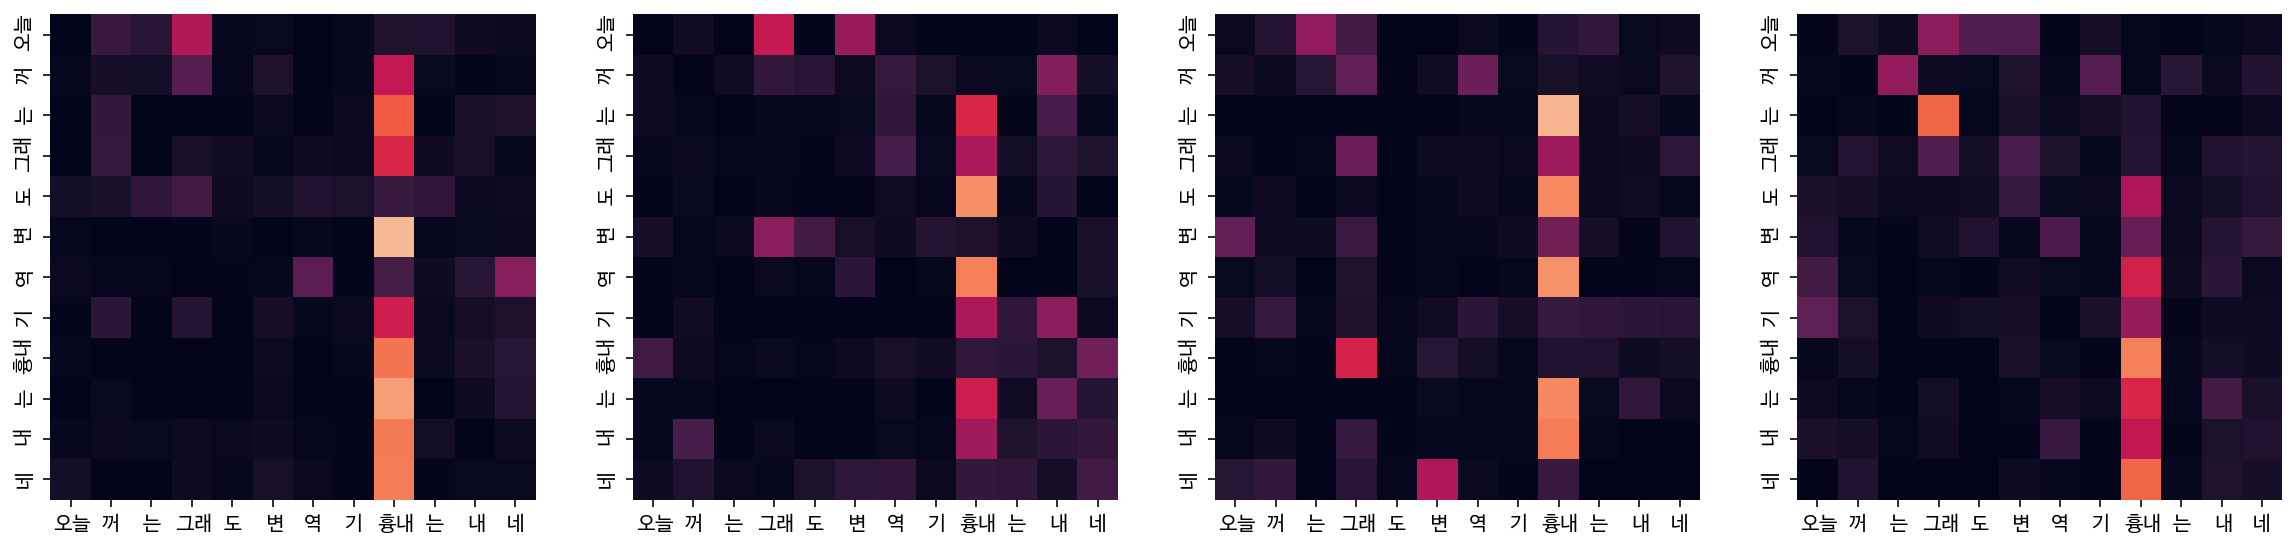

Encoder Layer 2


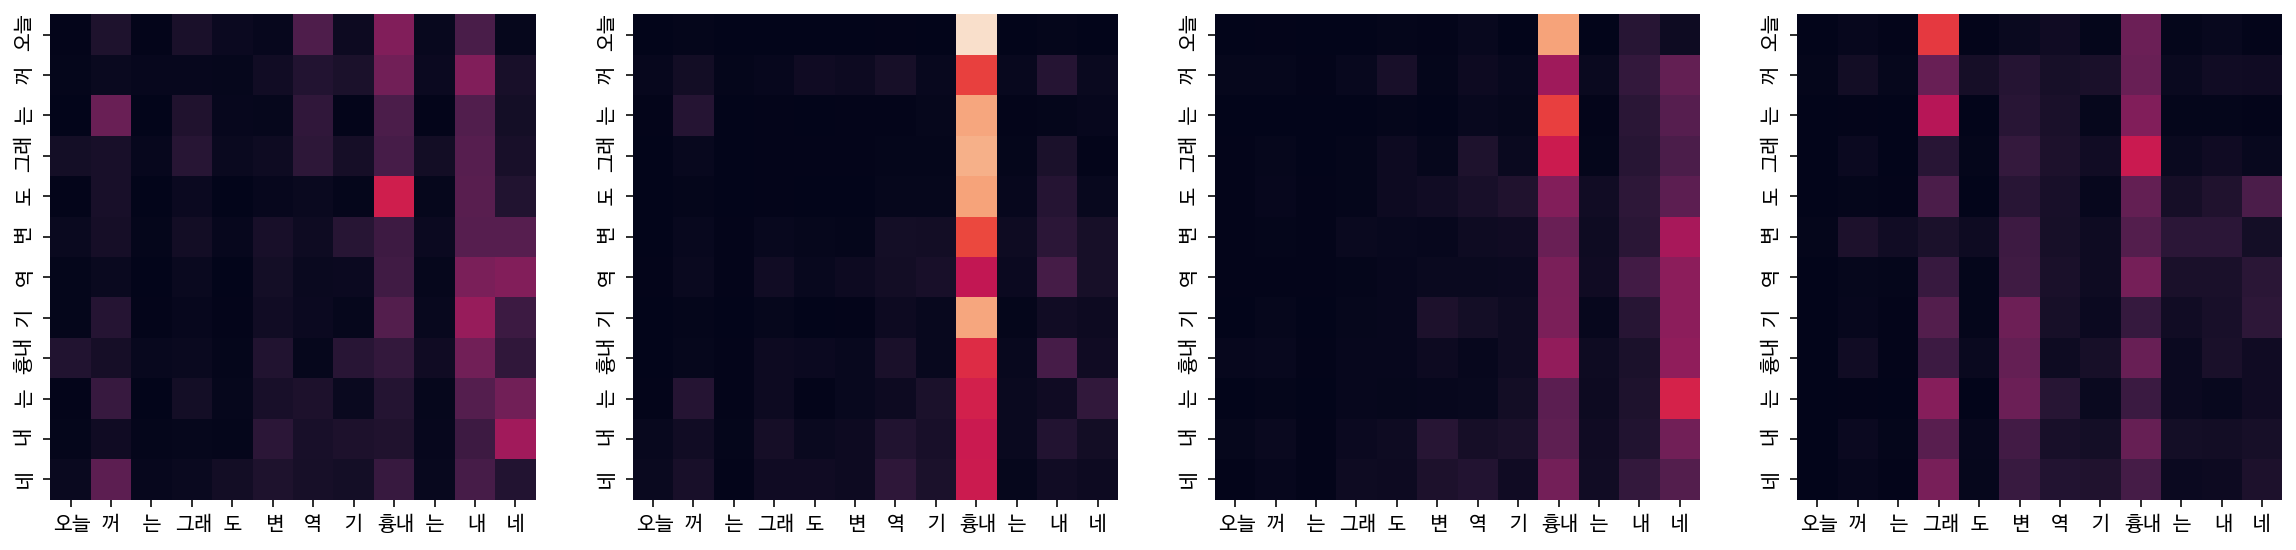

Decoder Self Layer 1


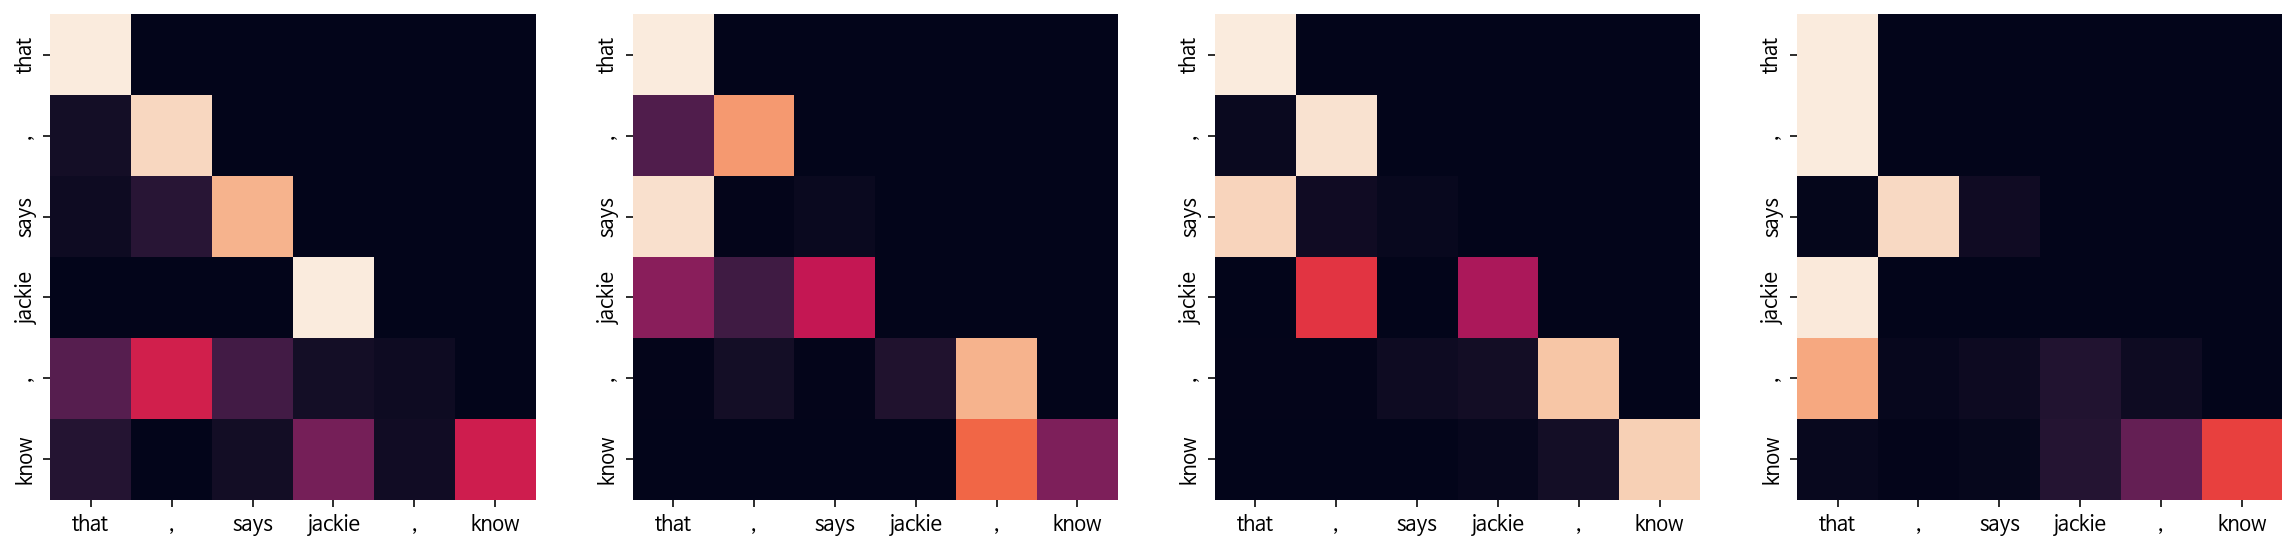

Decoder Src Layer 1


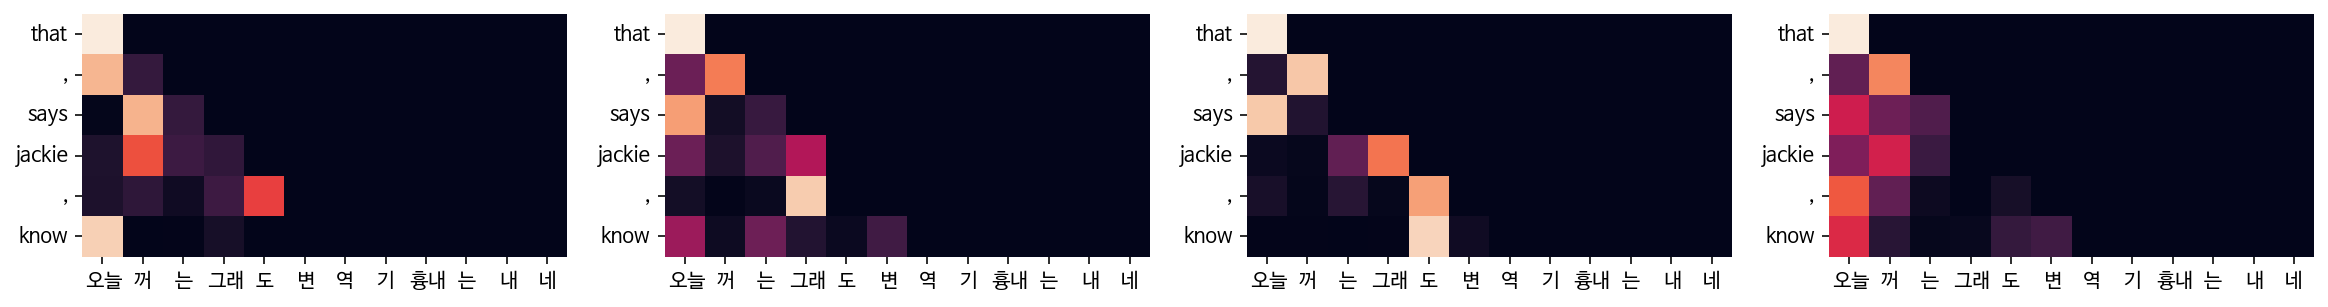

Decoder Self Layer 2


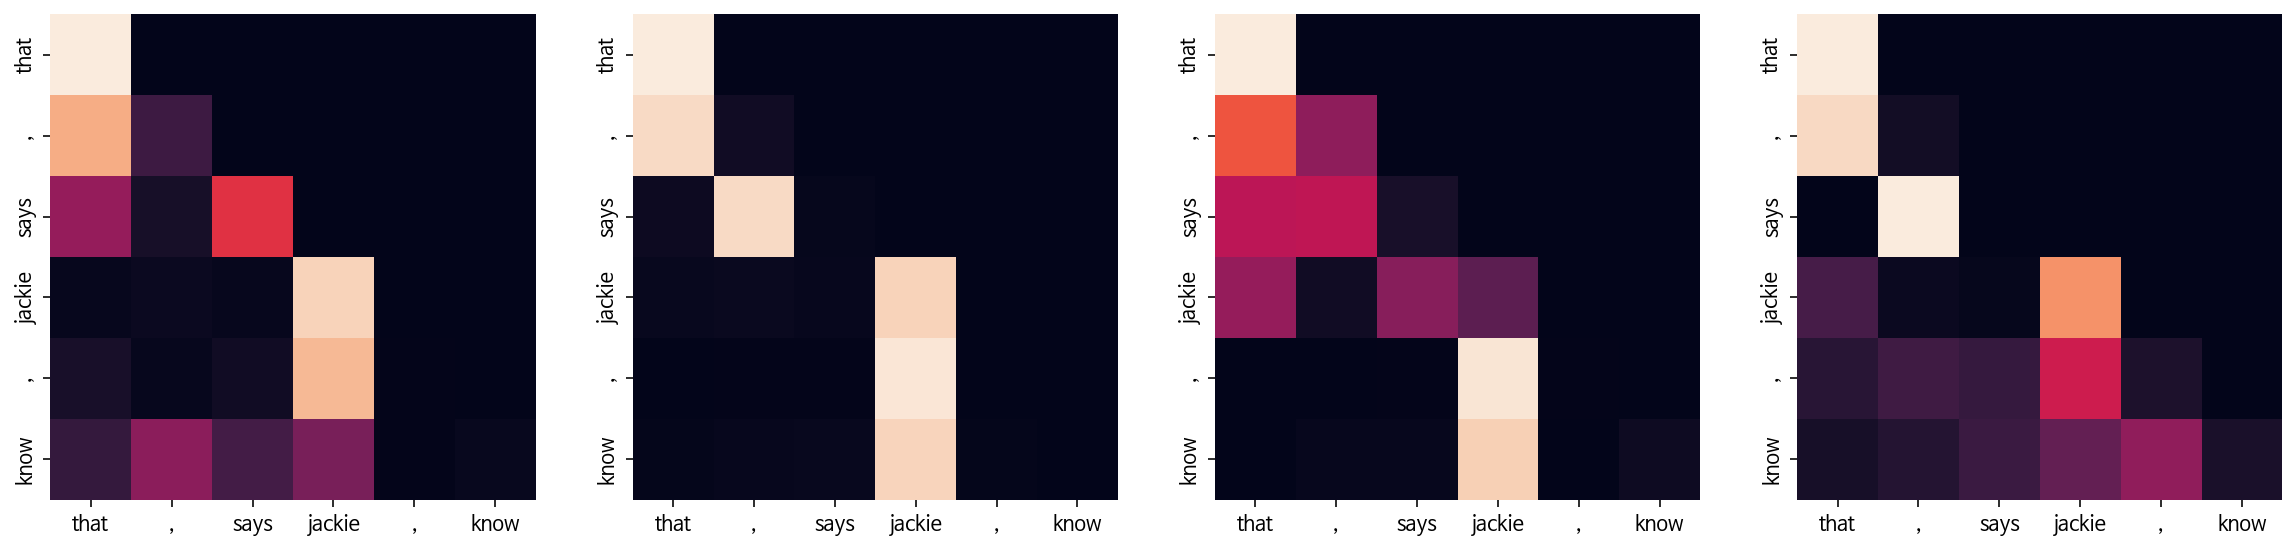

Decoder Src Layer 2


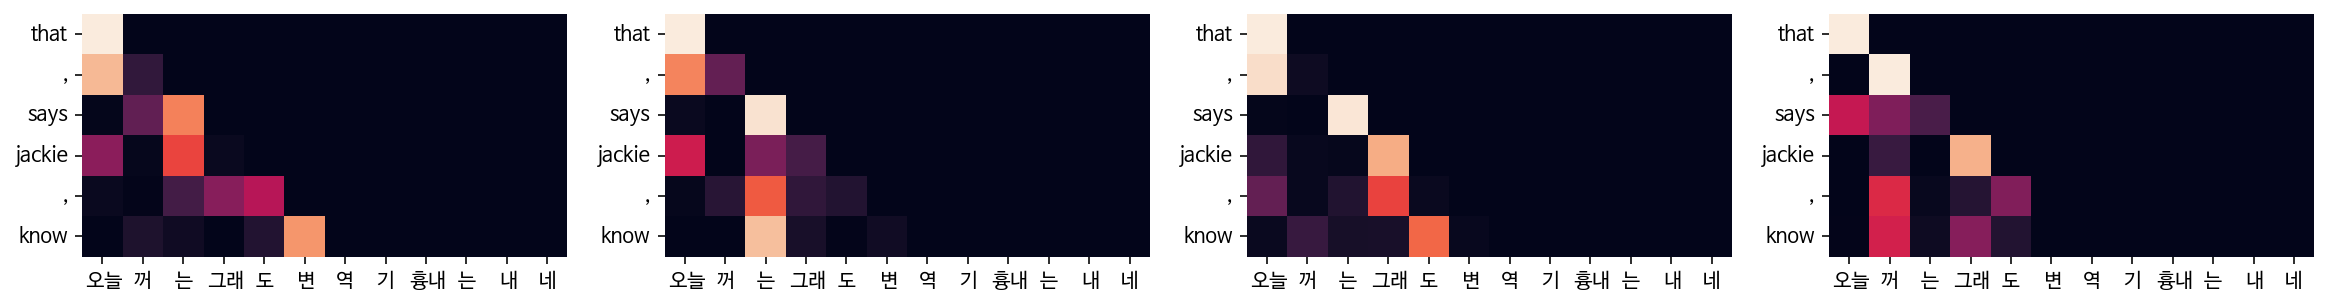

In [25]:
translate("오늘꺼는 그래도 변역기 흉내는 내네", transformer, ko_tokenizer, en_tokenizer,True)

Input: 나는 졸리다
Predicted translation: i jolie said jolie is the joliet .
Encoder Layer 1


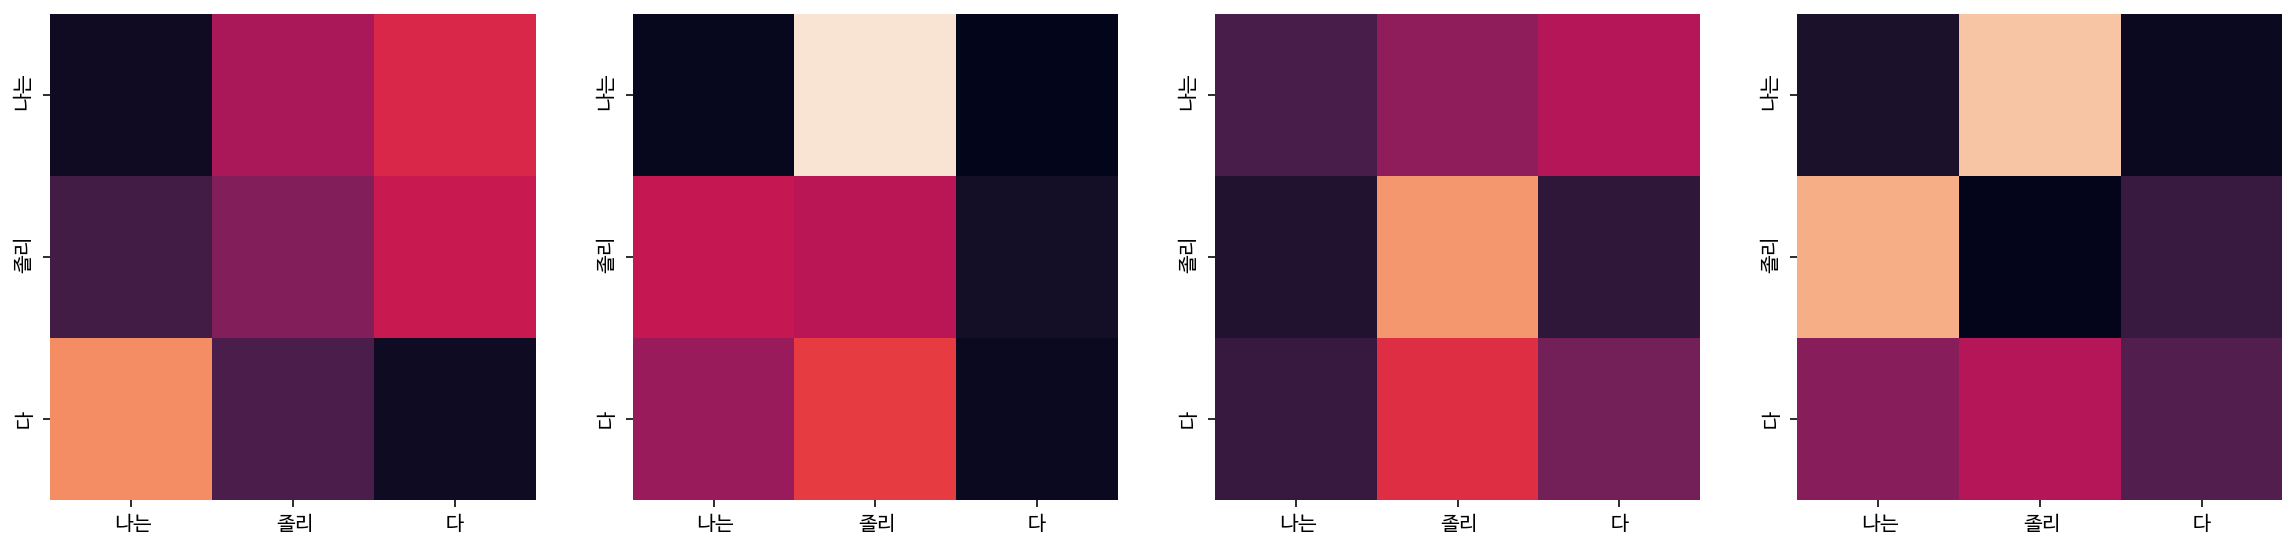

Encoder Layer 2


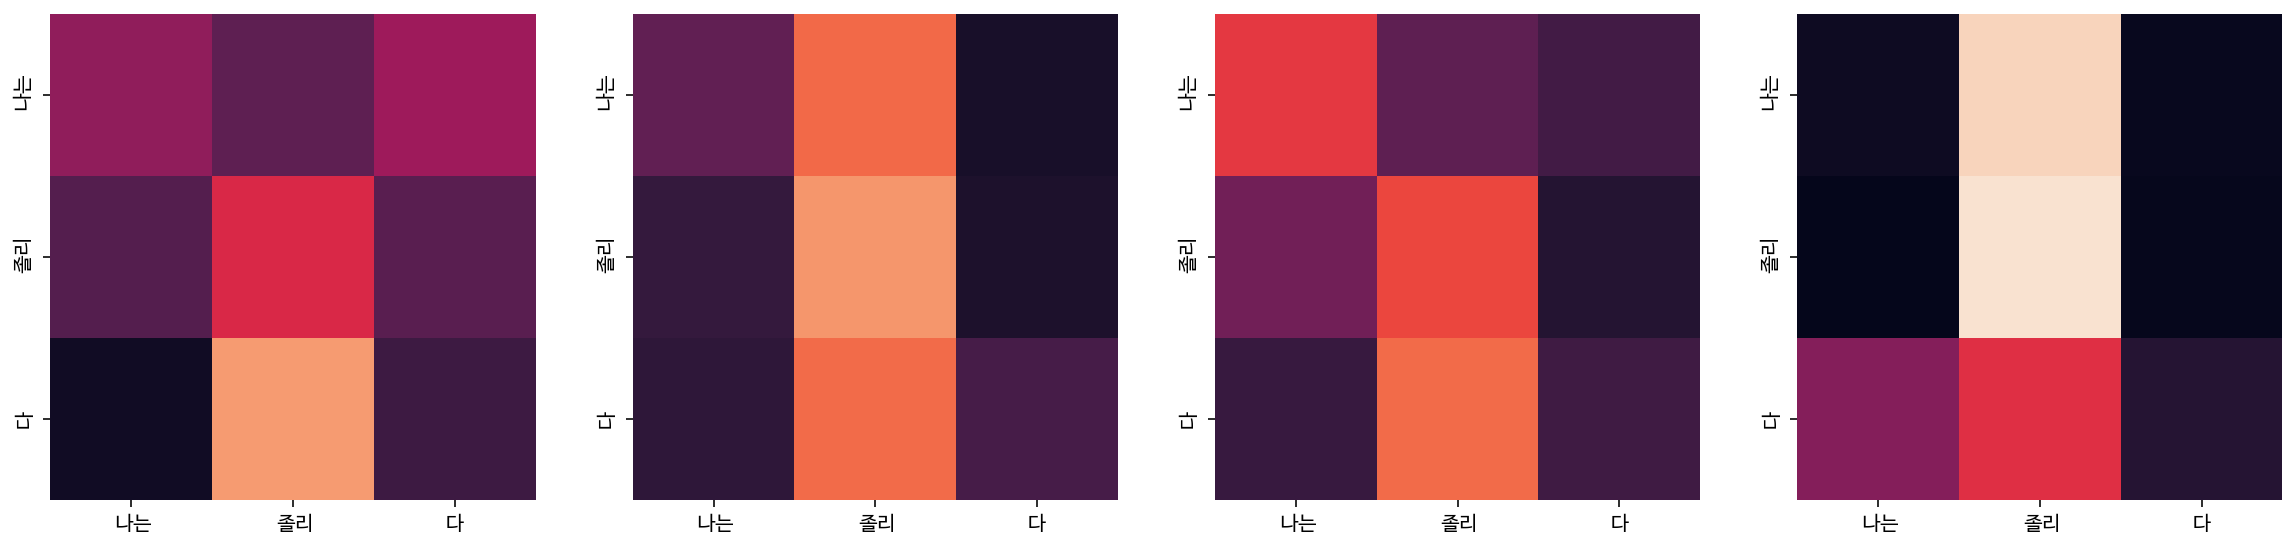

Decoder Self Layer 1


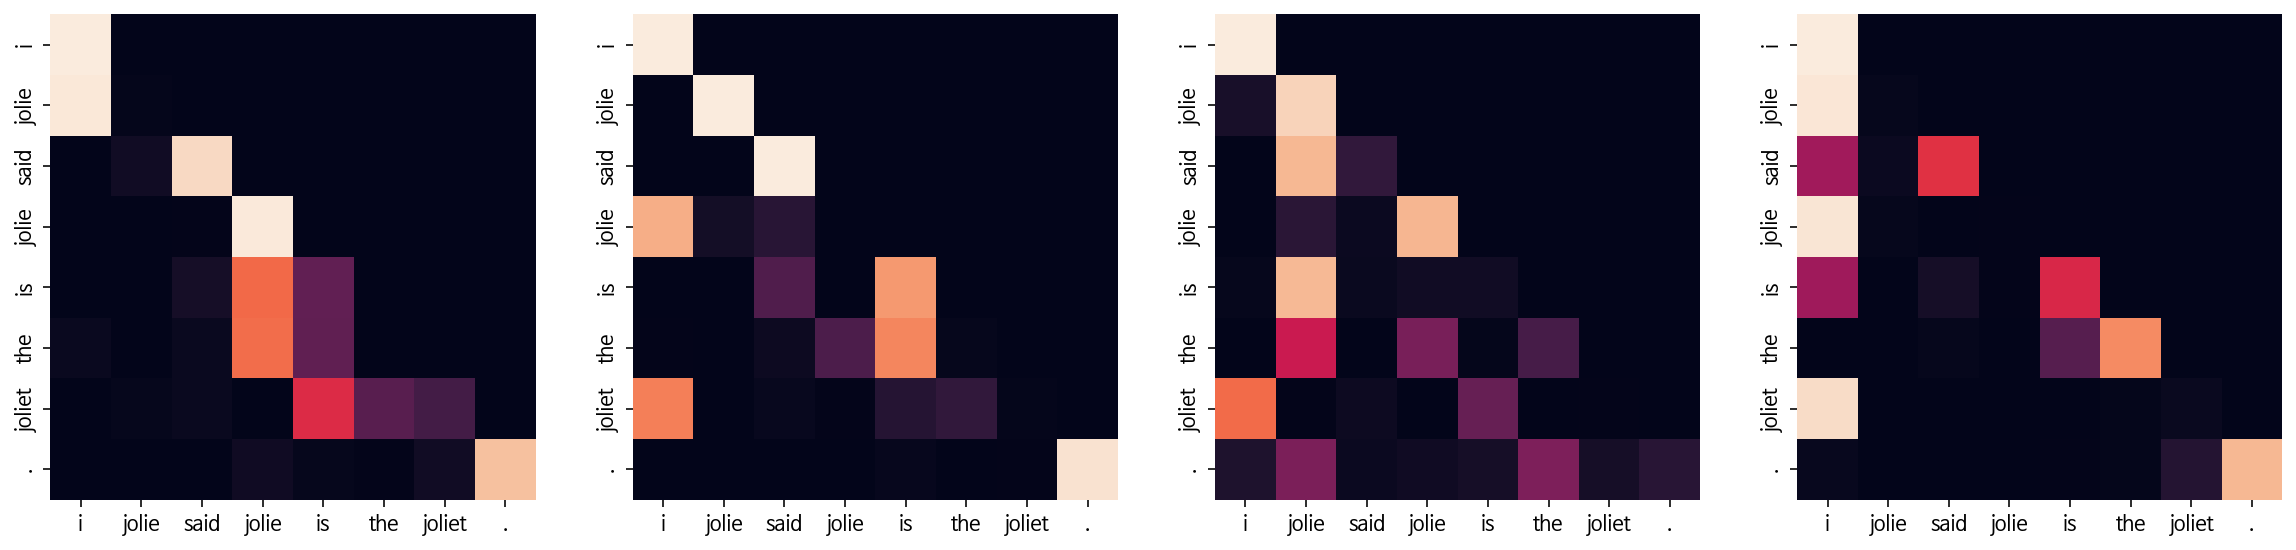

Decoder Src Layer 1


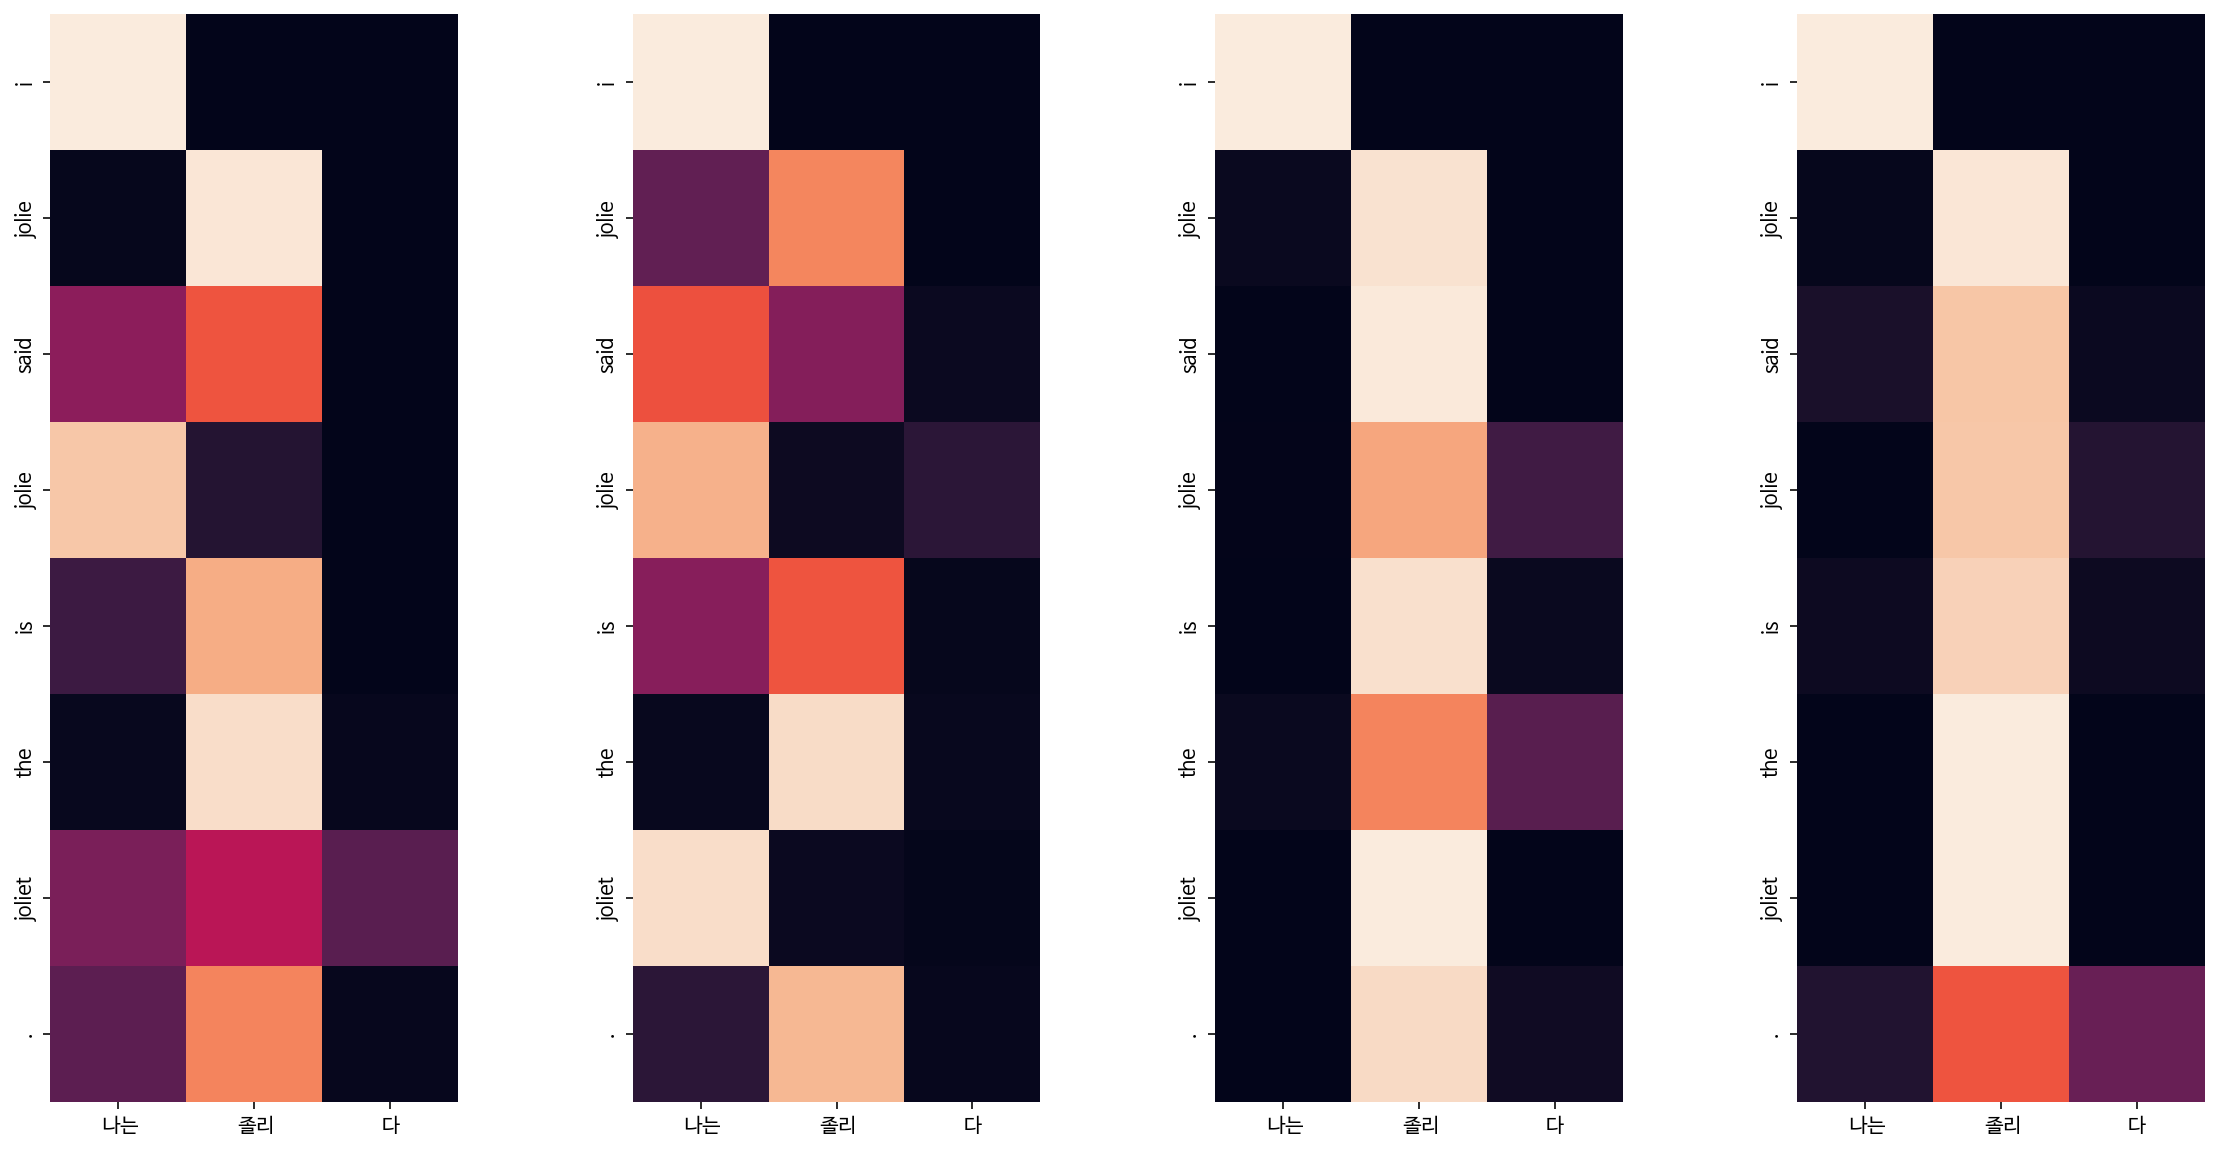

Decoder Self Layer 2


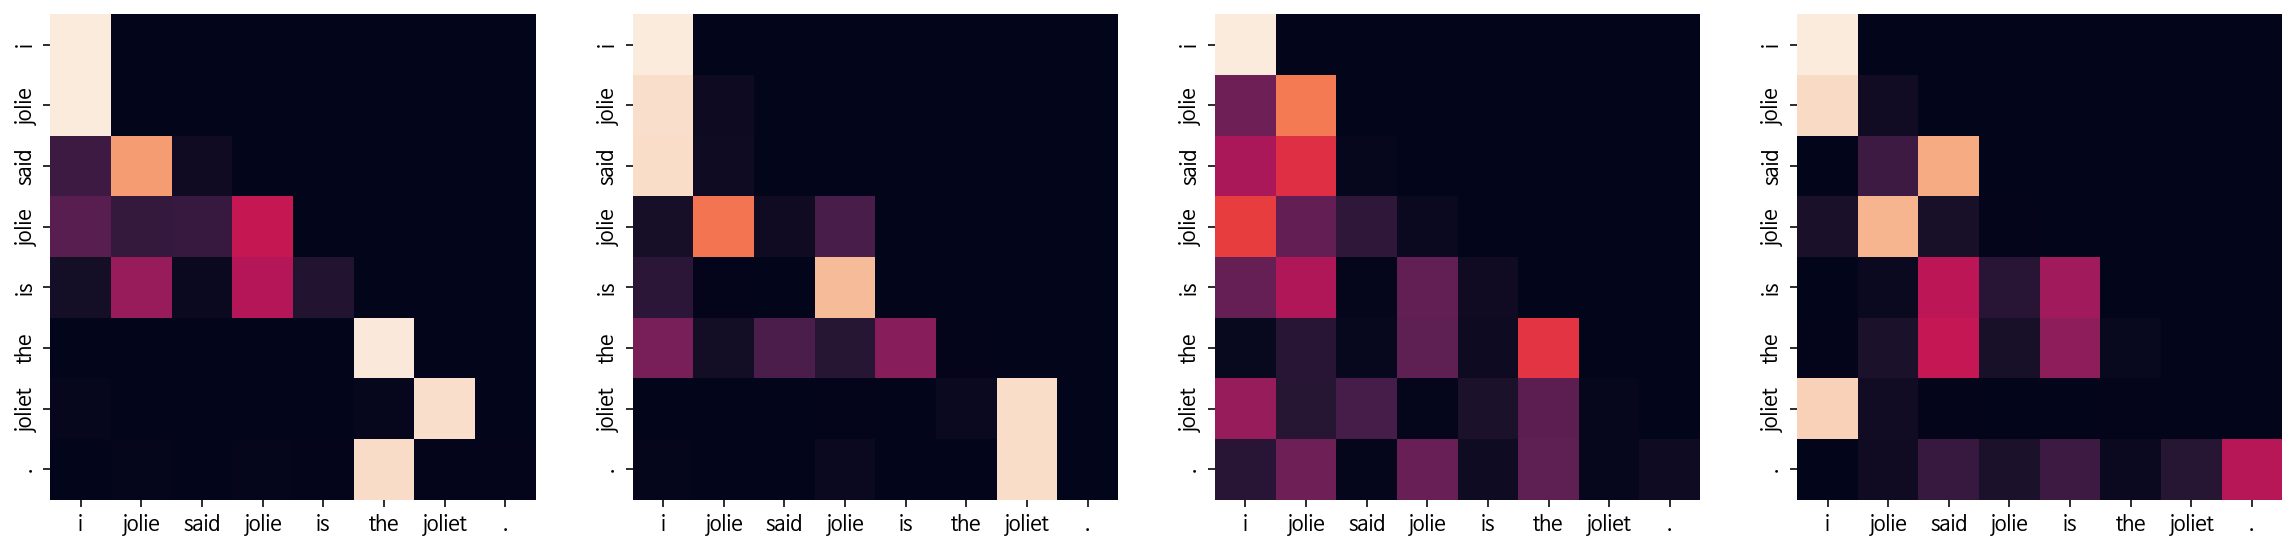

Decoder Src Layer 2


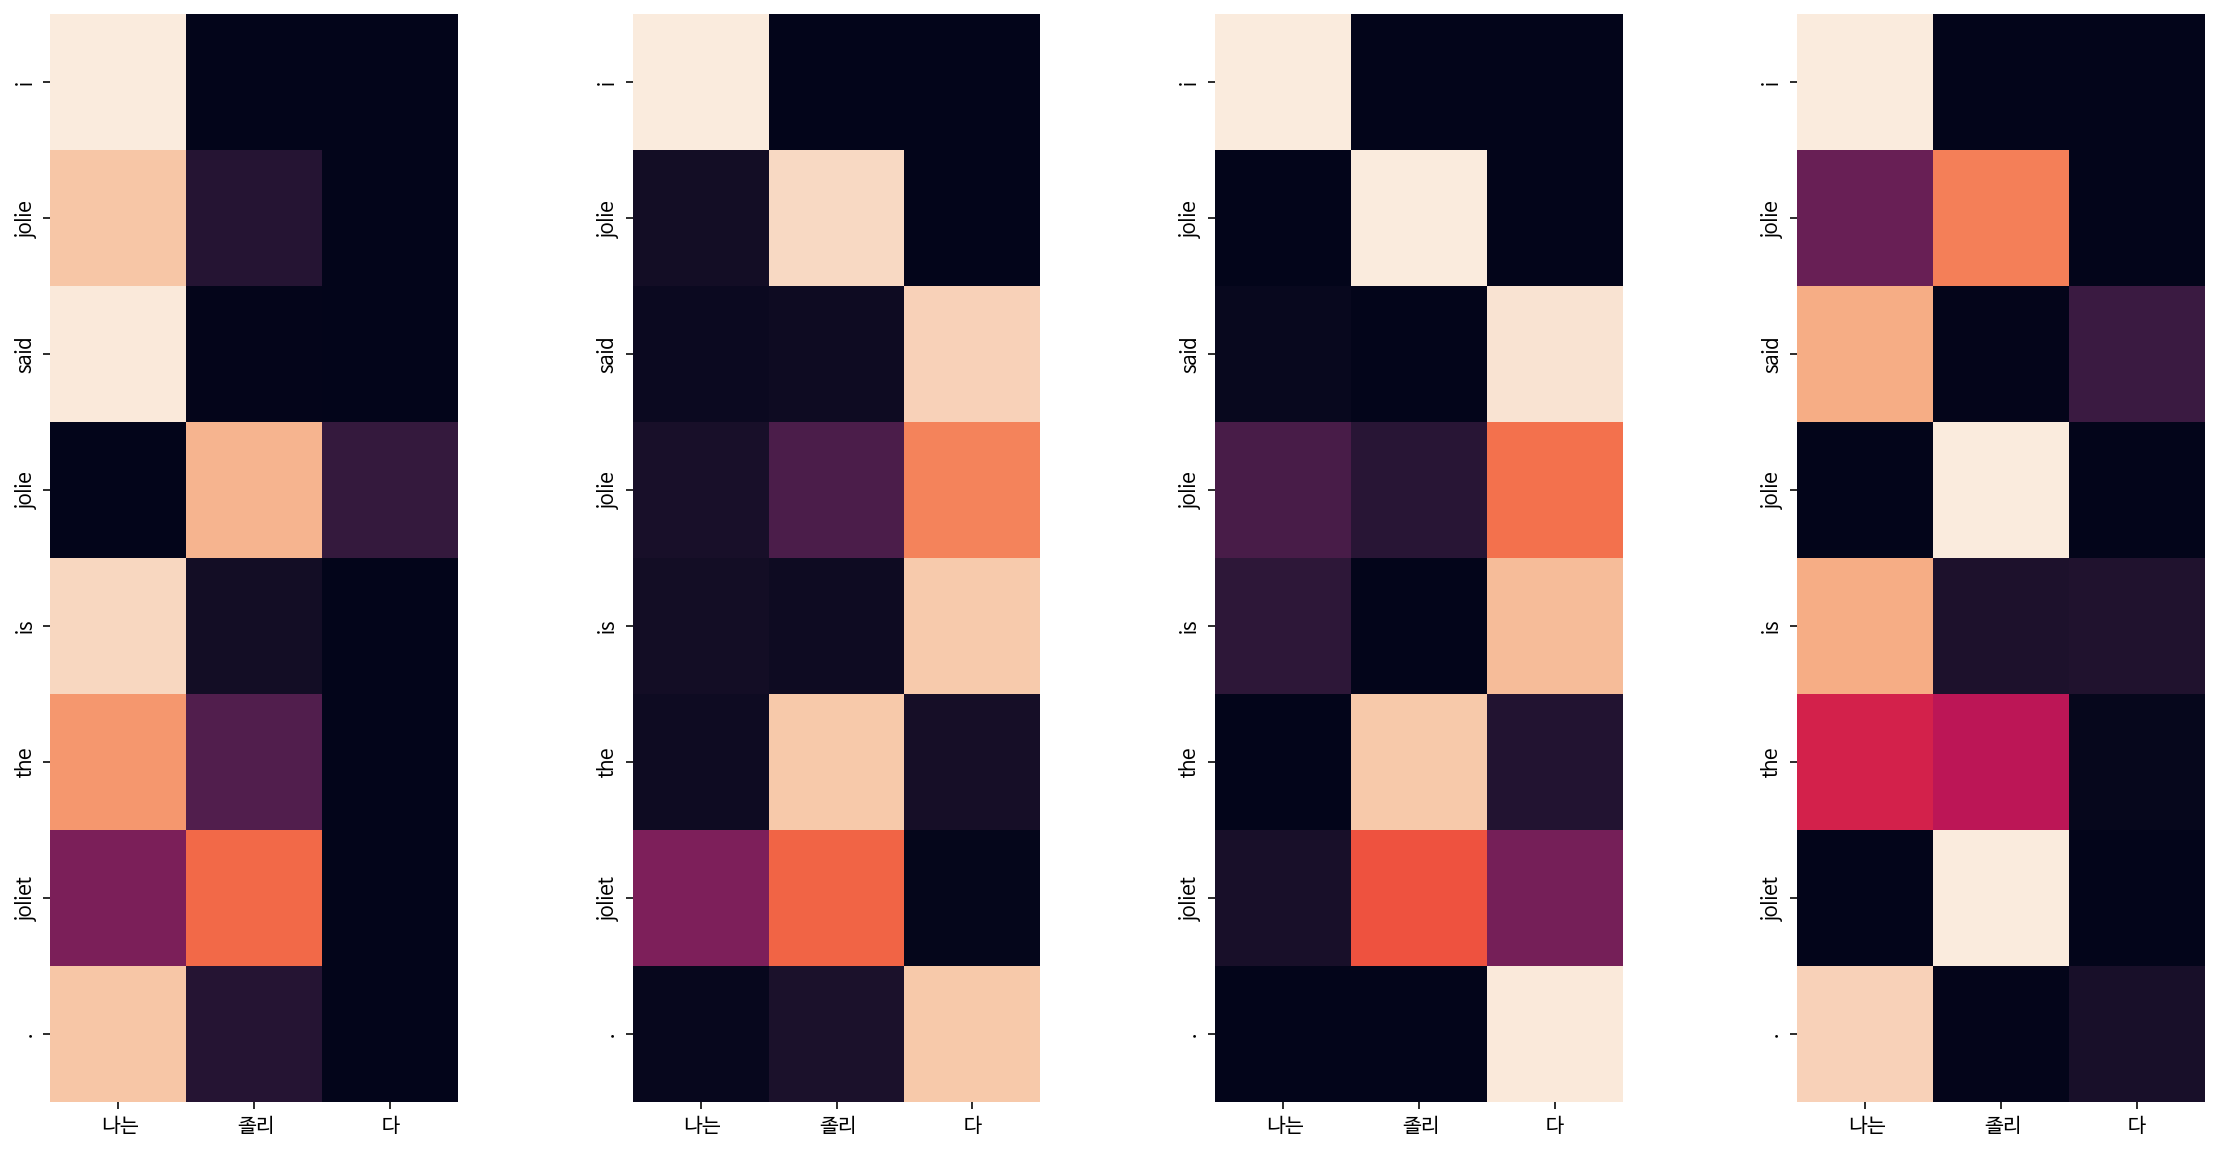

In [26]:
translate("나는 졸리다", transformer, ko_tokenizer, en_tokenizer,True)

Input: 저것은 사과입니다
Predicted translation: i think the apology is going to work offensive in the middle of these road brought in our apologize .
Encoder Layer 1


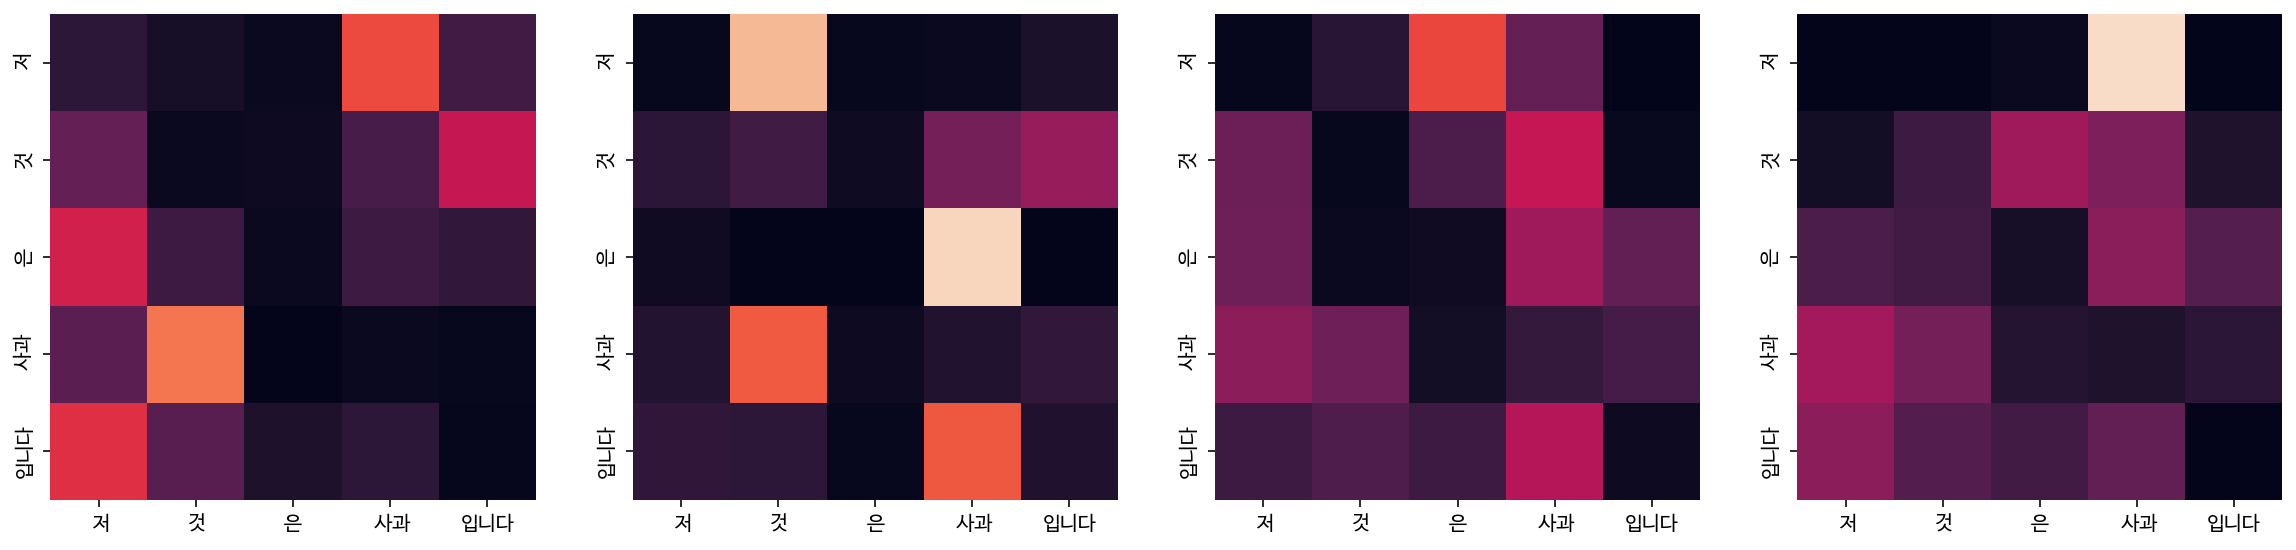

Encoder Layer 2


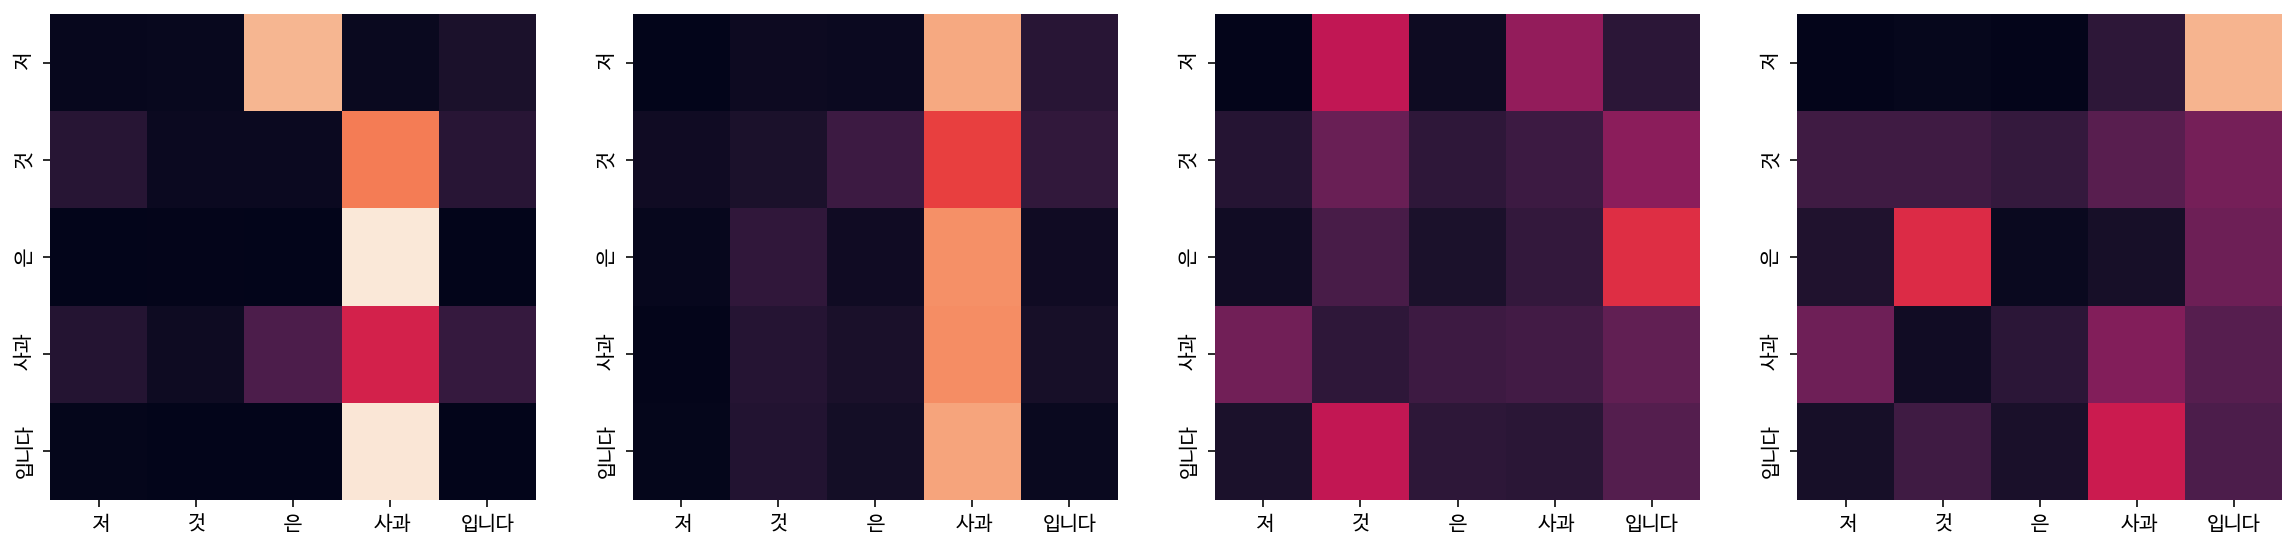

Decoder Self Layer 1


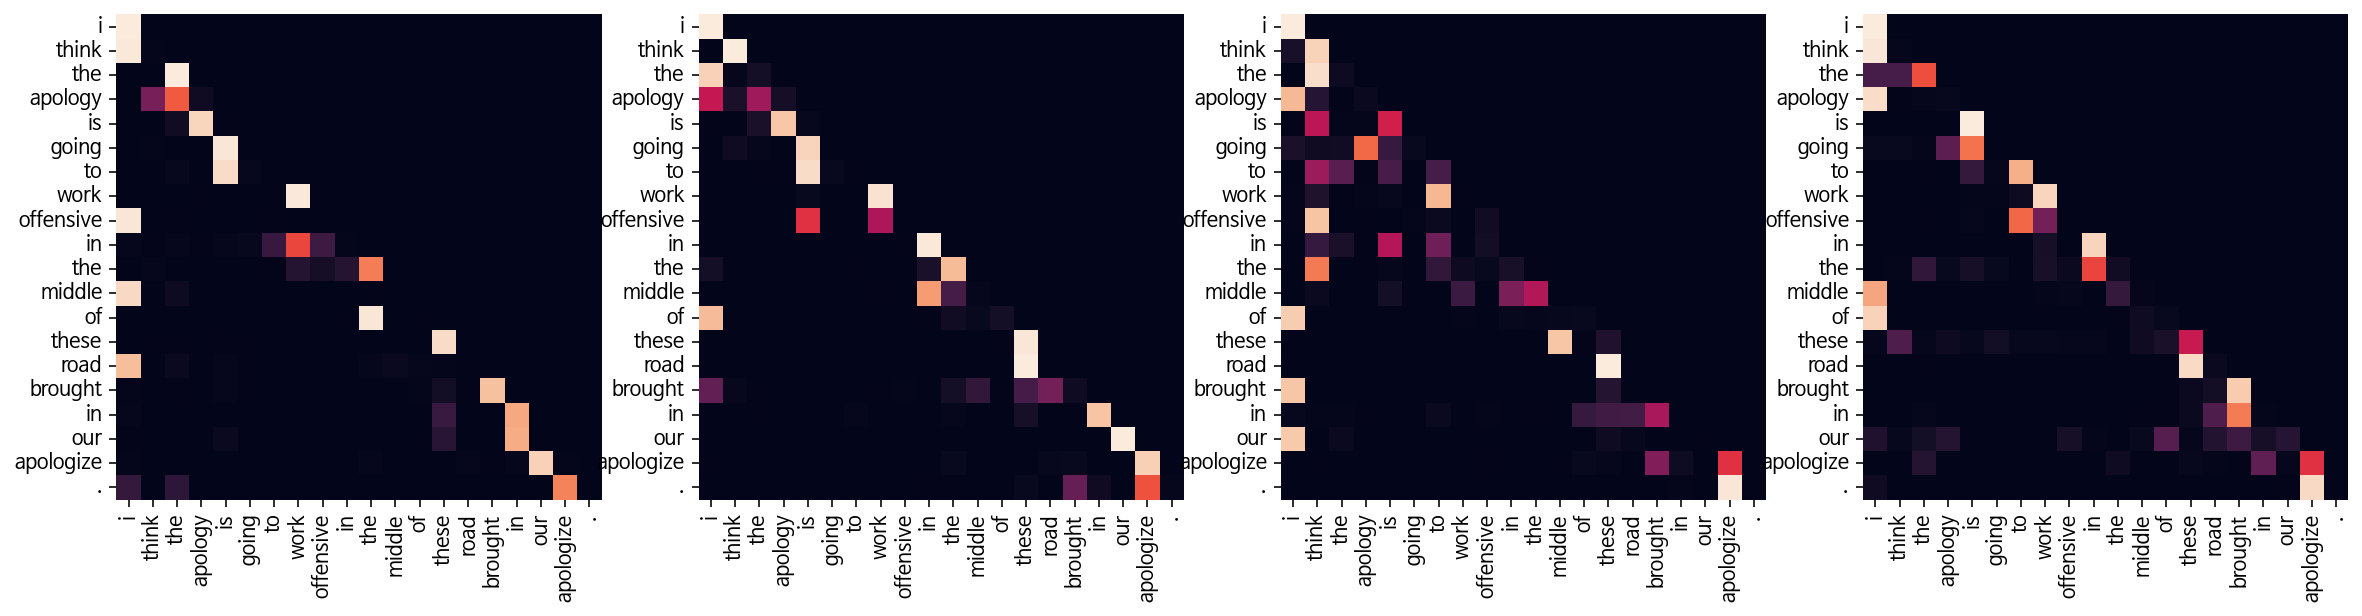

Decoder Src Layer 1


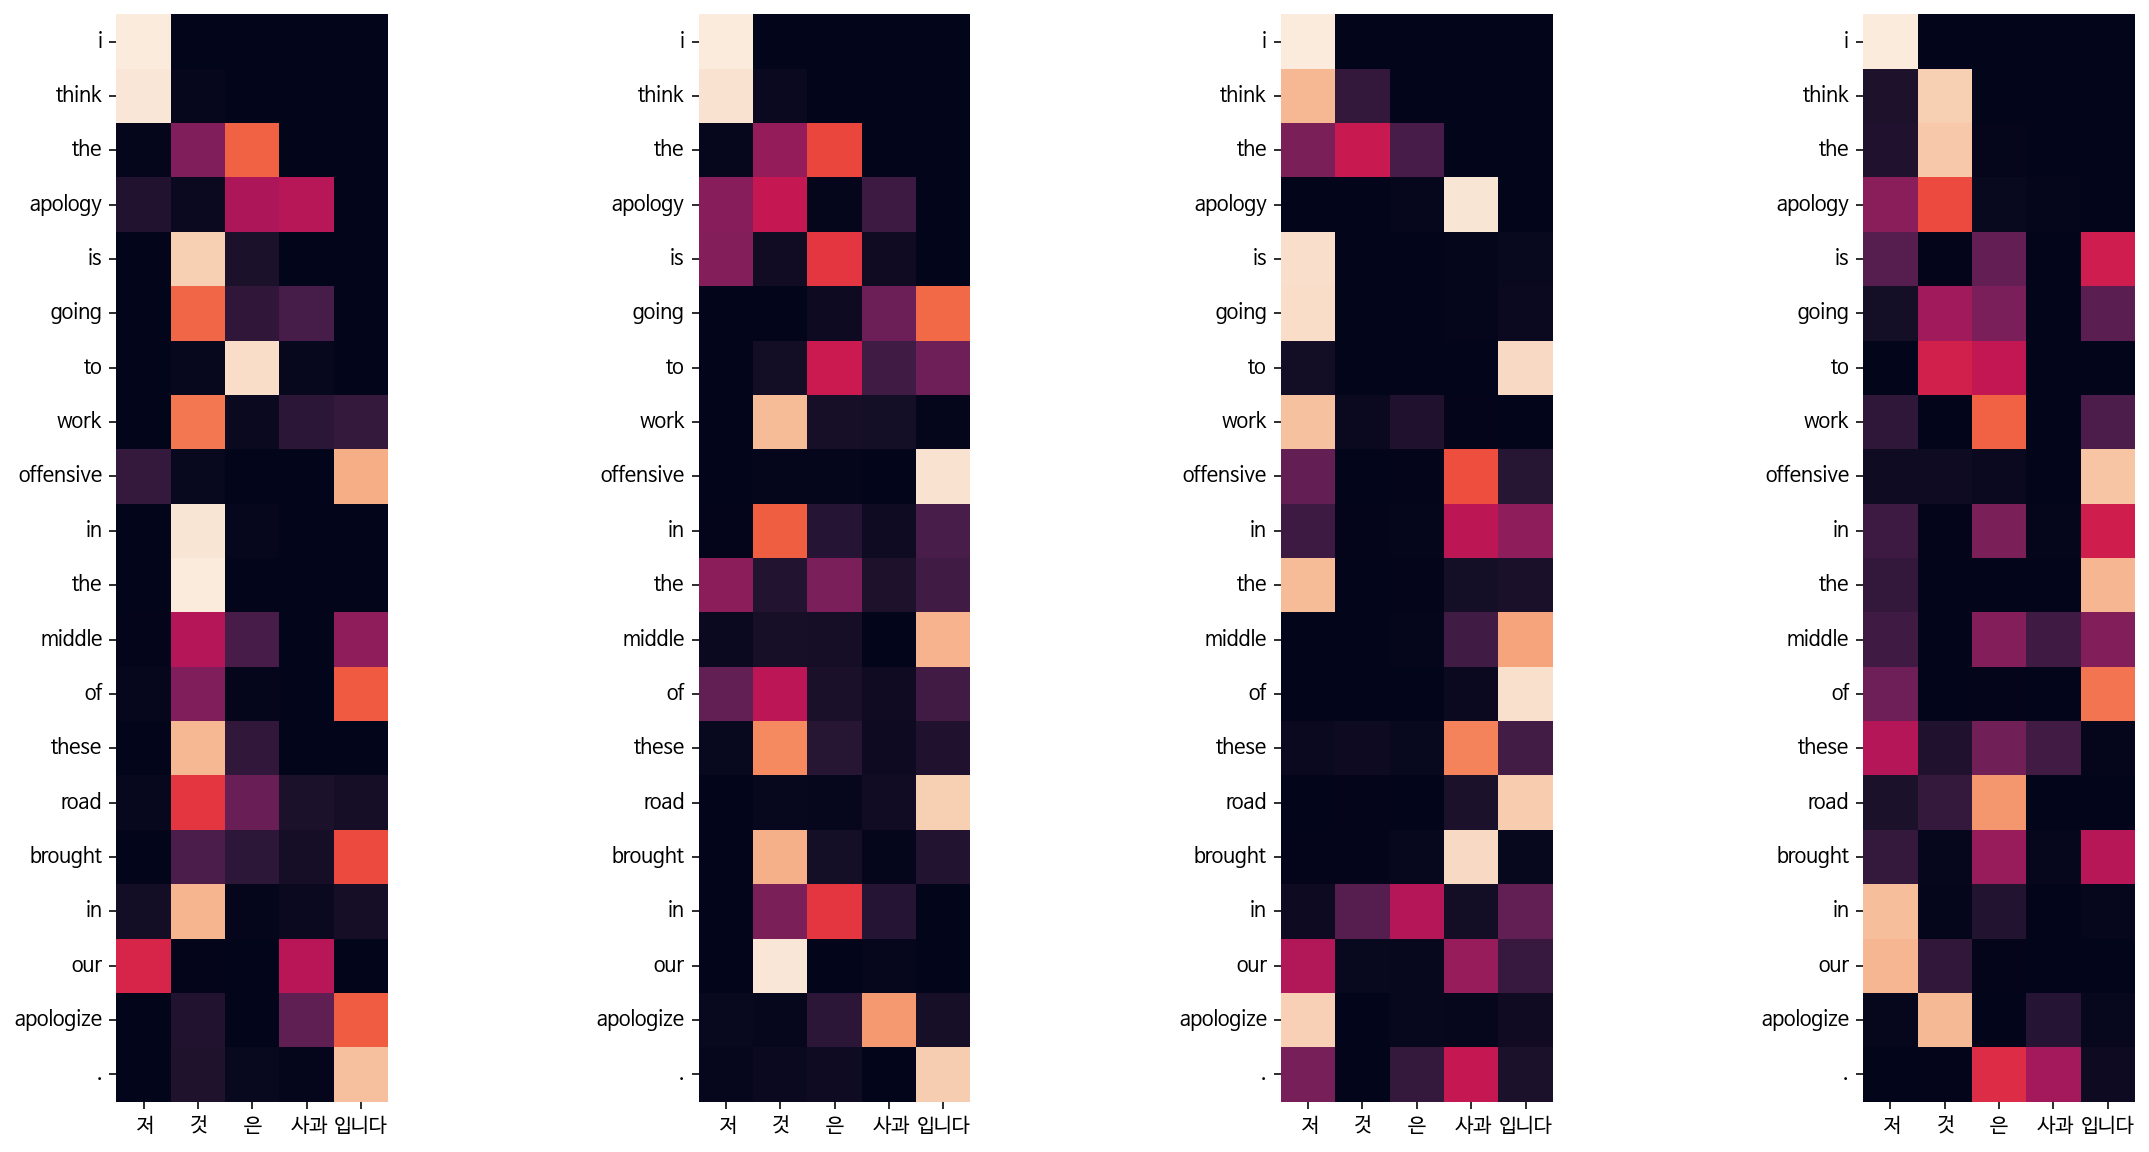

Decoder Self Layer 2


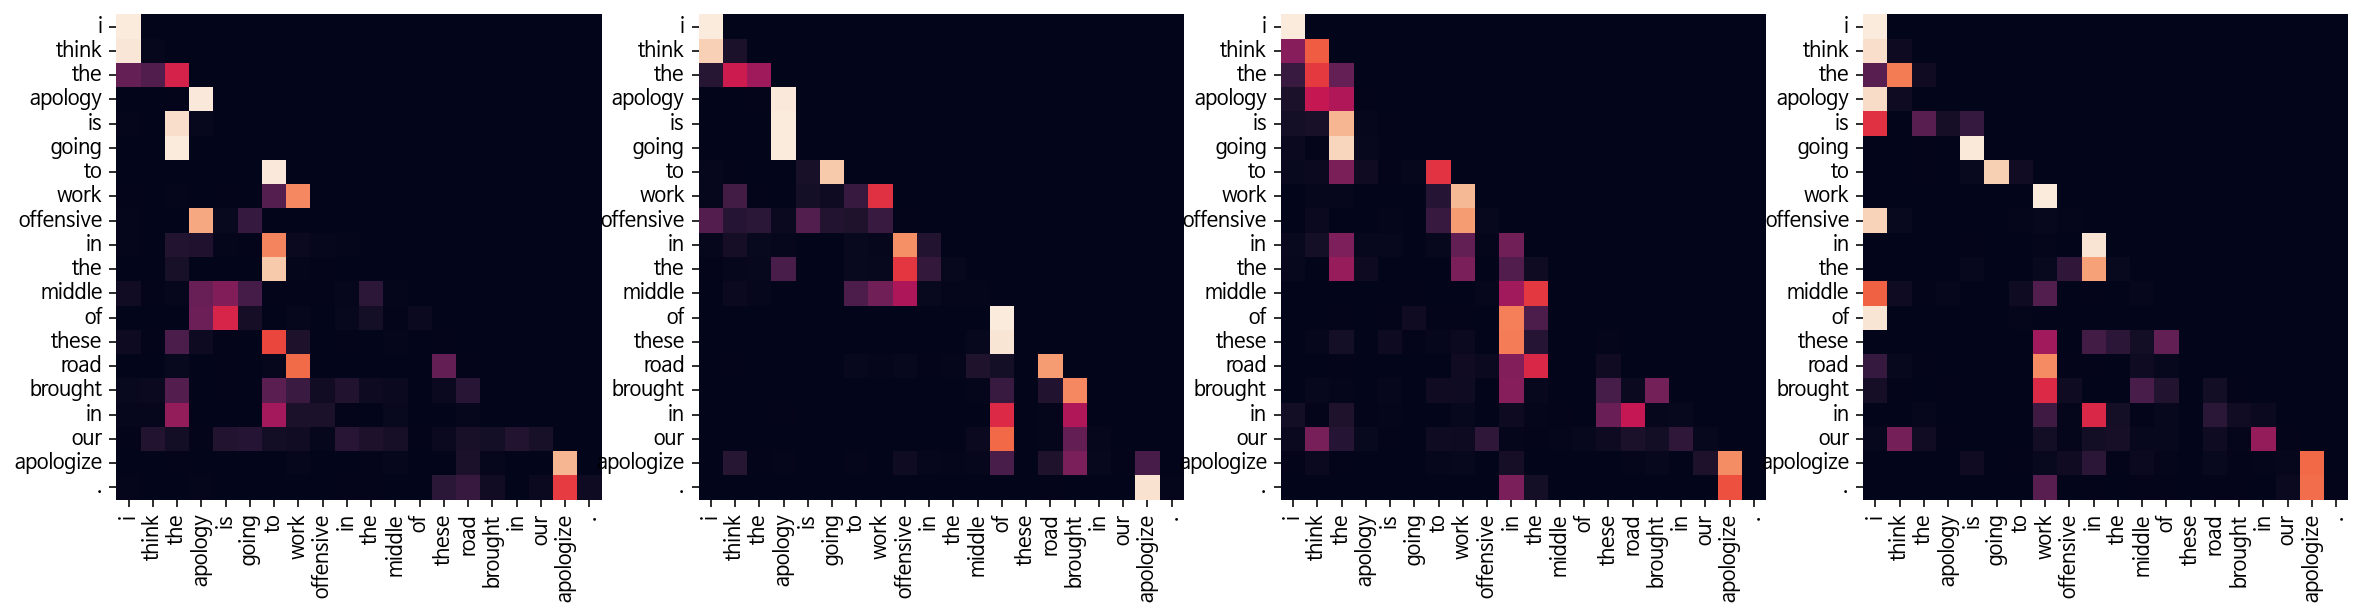

Decoder Src Layer 2


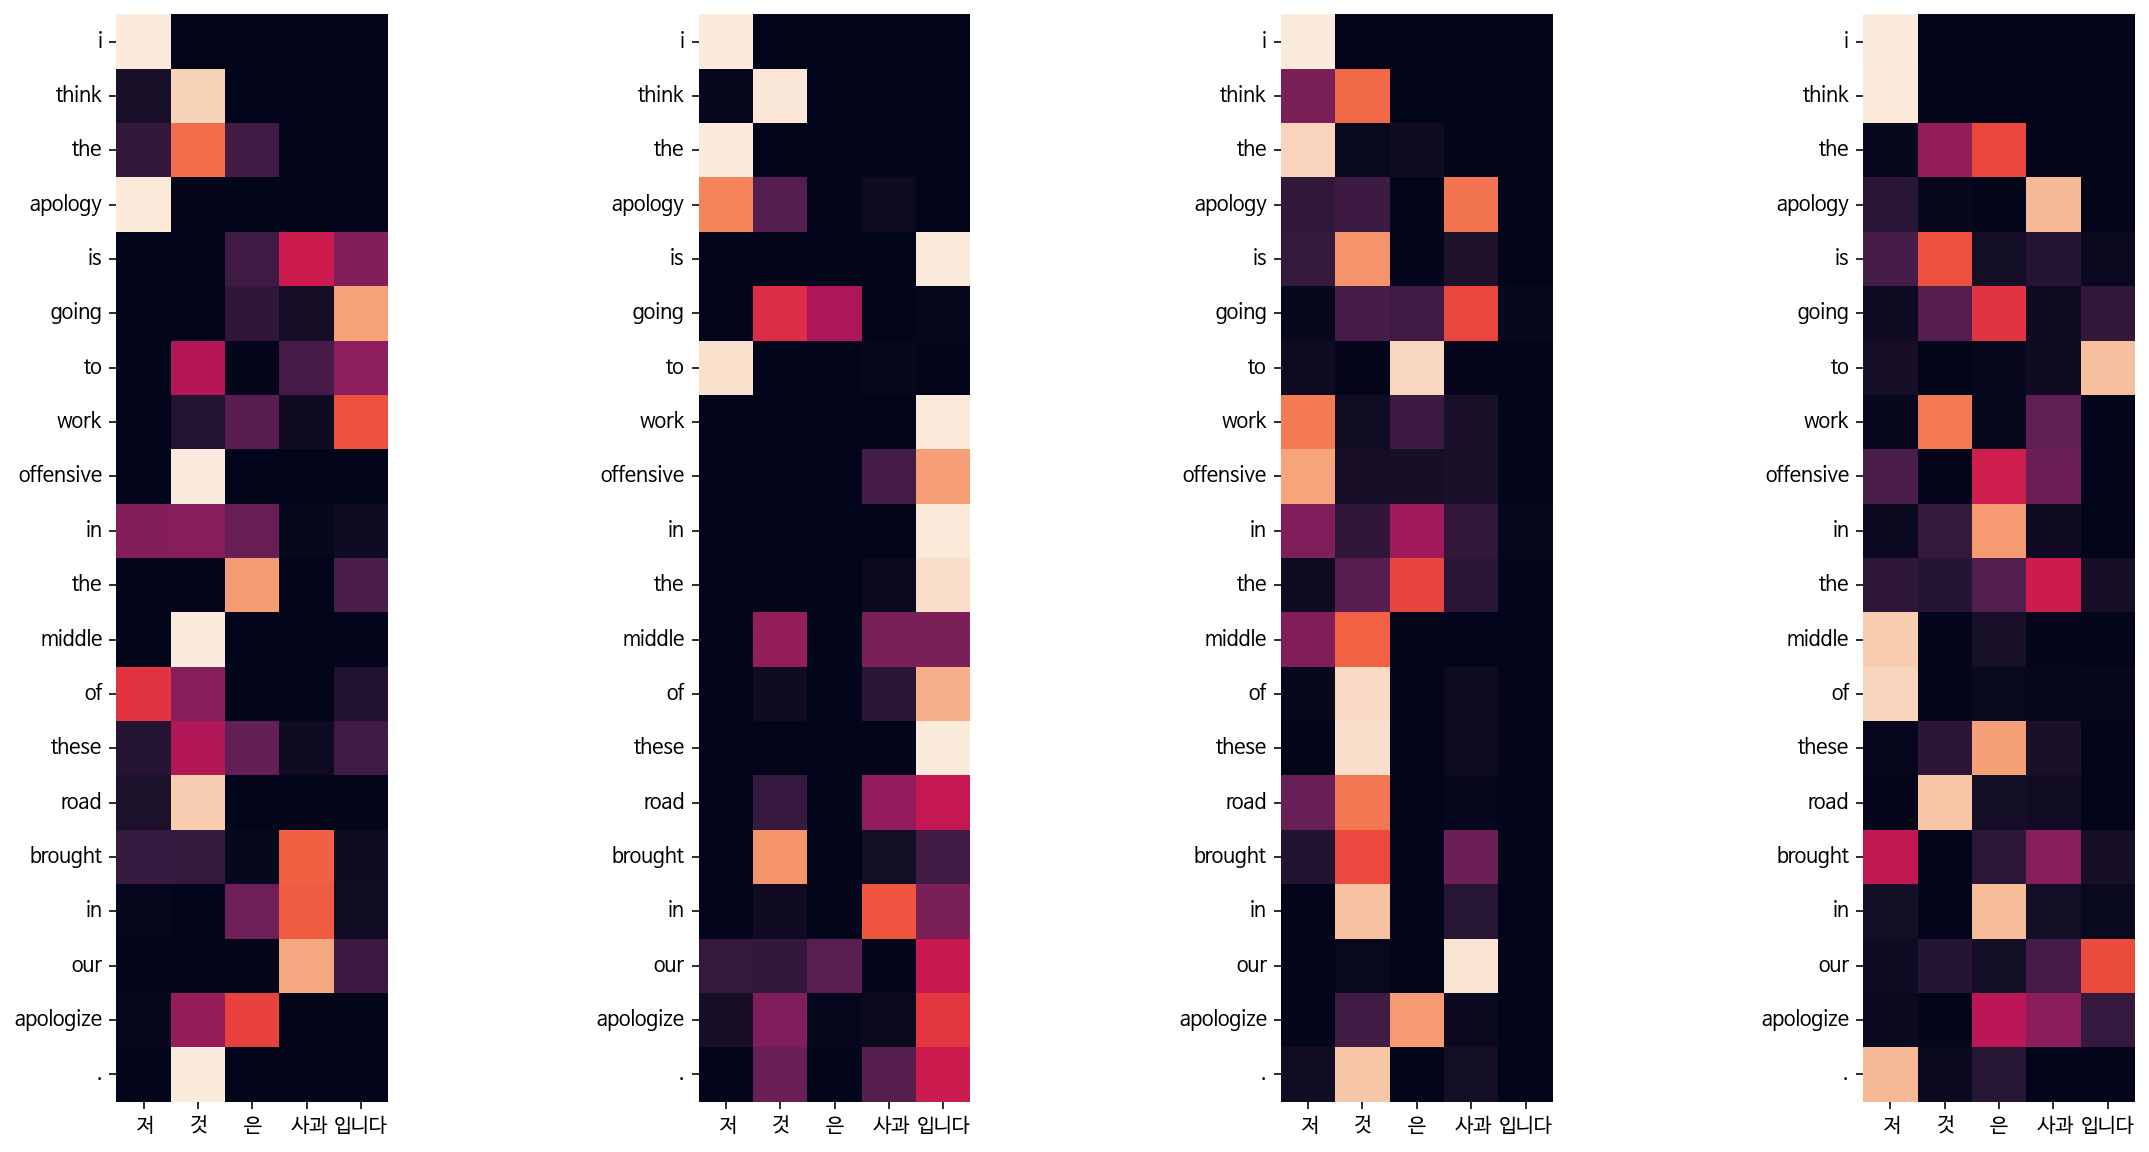

In [27]:
translate("저것은 사과입니다", transformer, ko_tokenizer, en_tokenizer,True)

Input: 점심은 맛있습니다.
Predicted translation: that senses take the day .
Encoder Layer 1


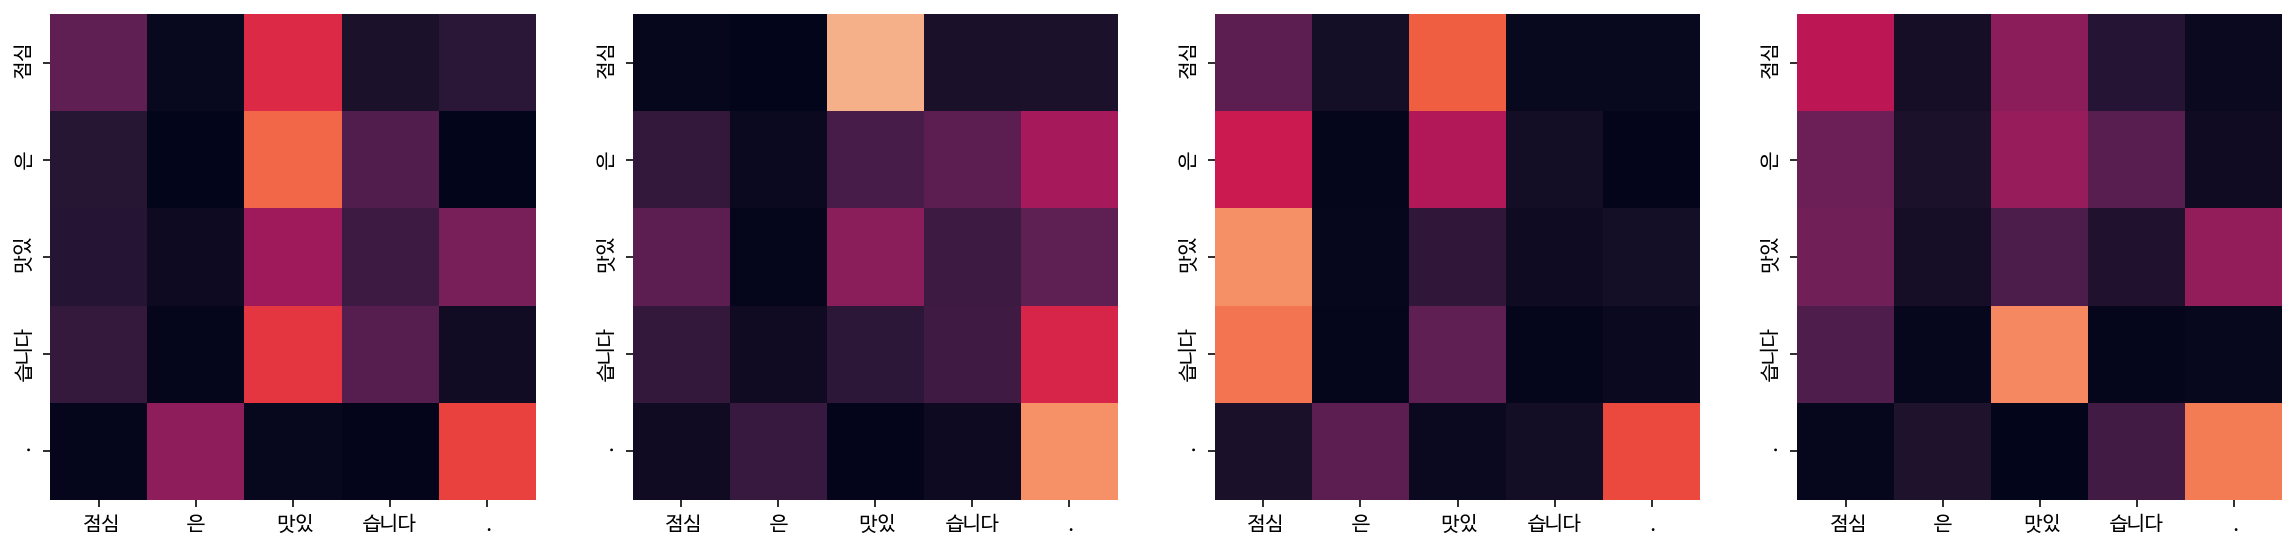

Encoder Layer 2


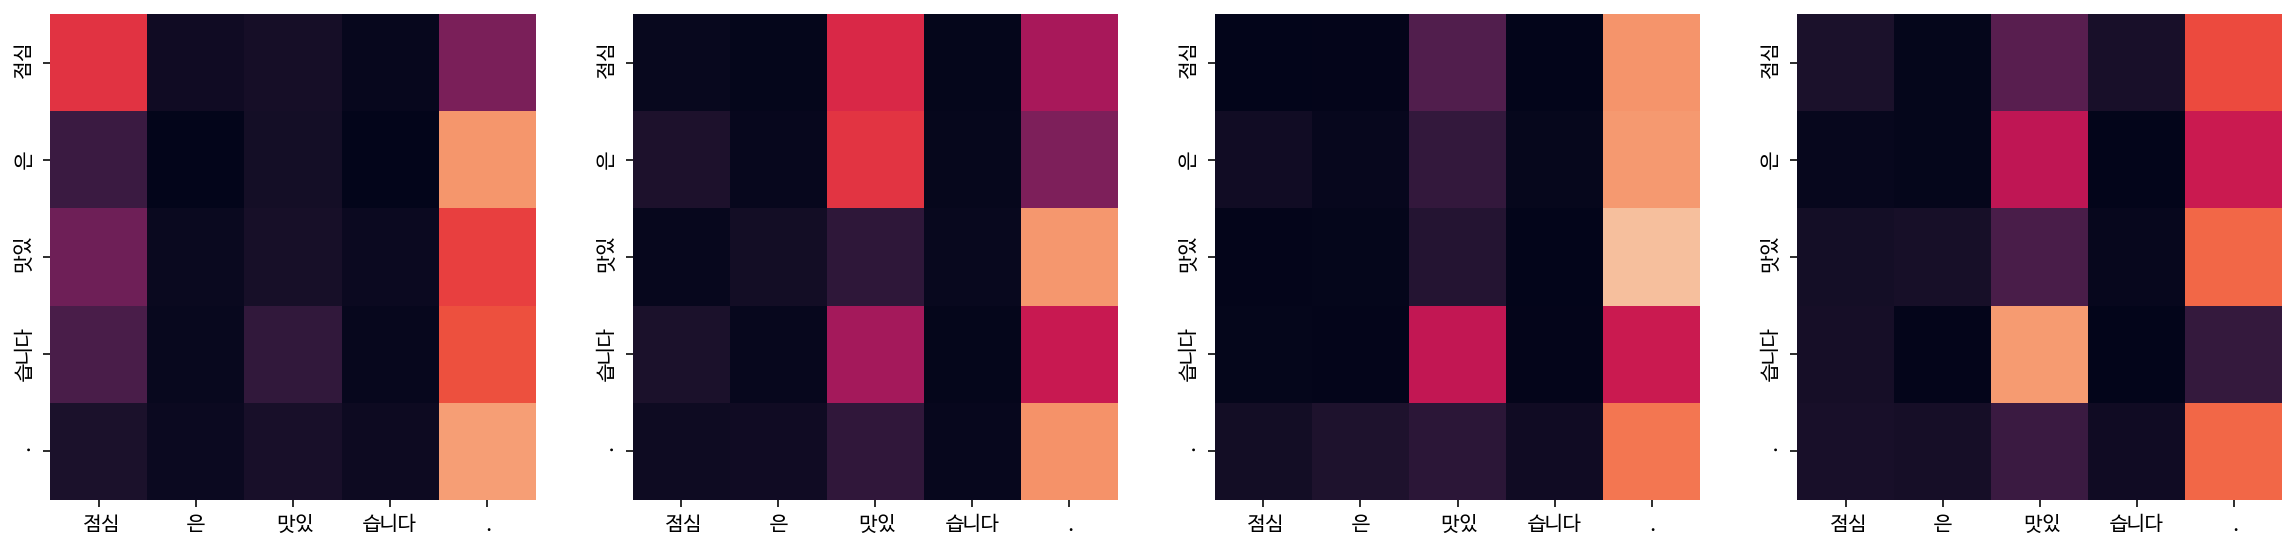

Decoder Self Layer 1


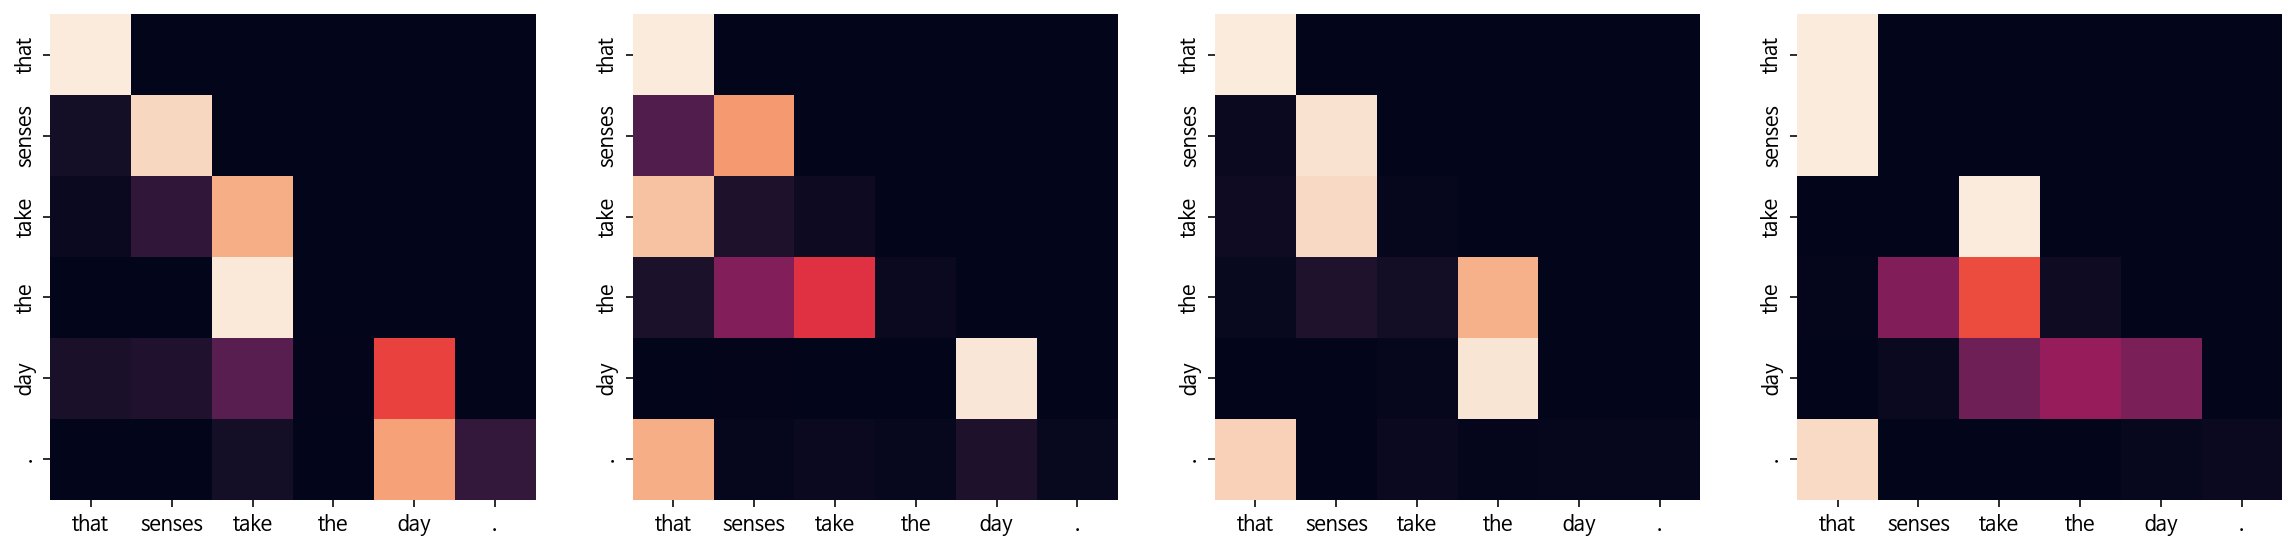

Decoder Src Layer 1


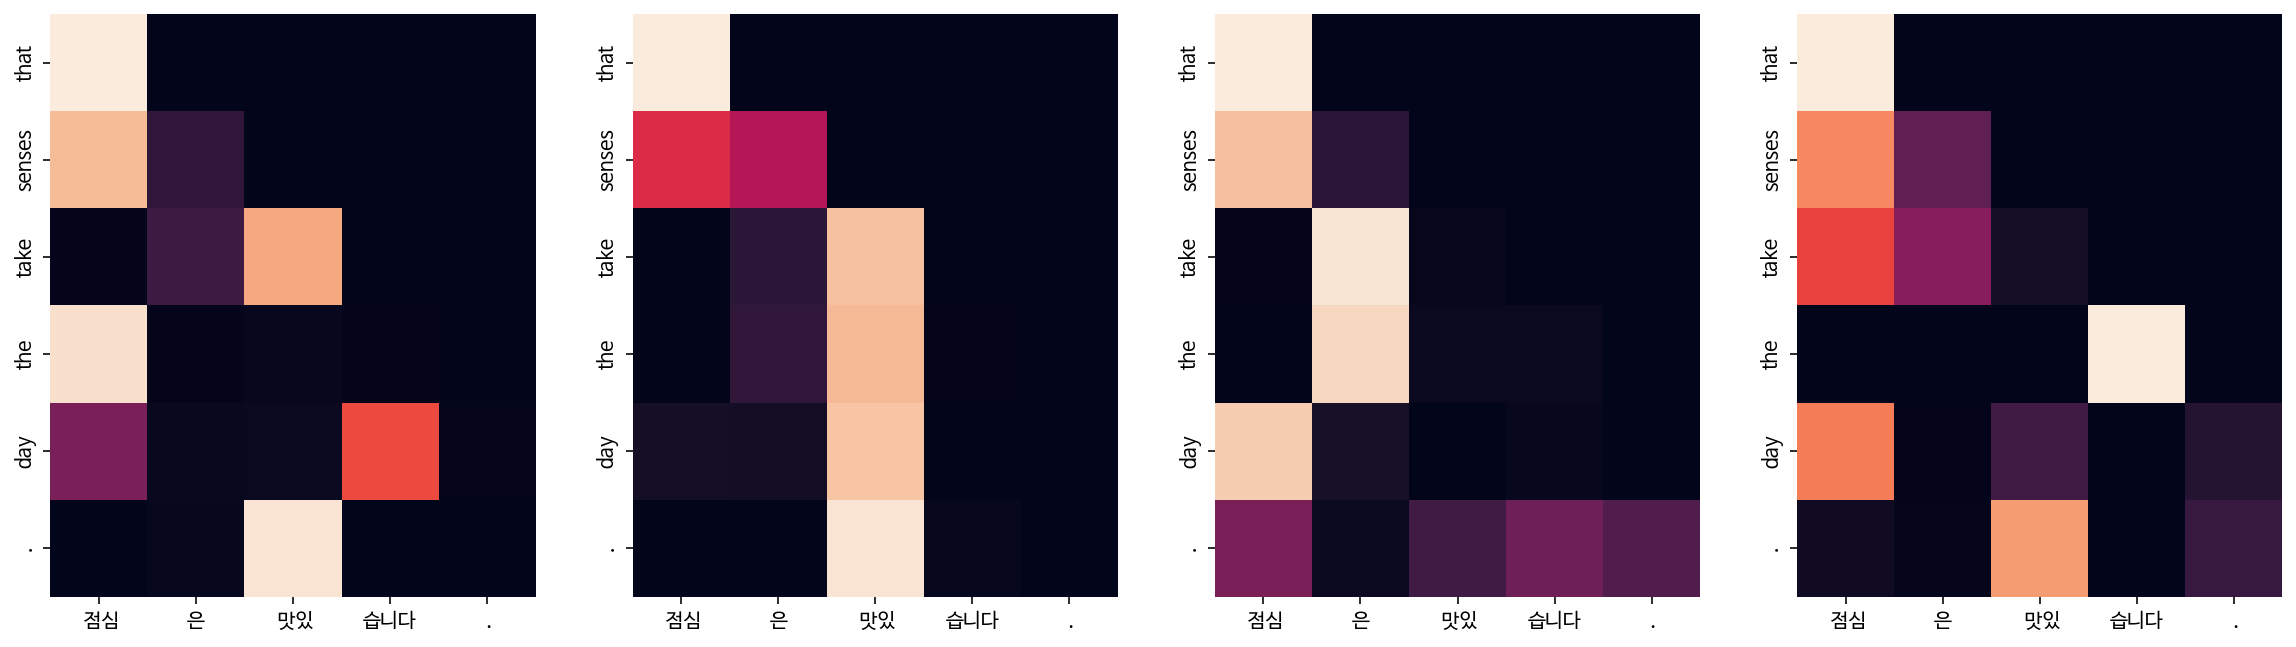

Decoder Self Layer 2


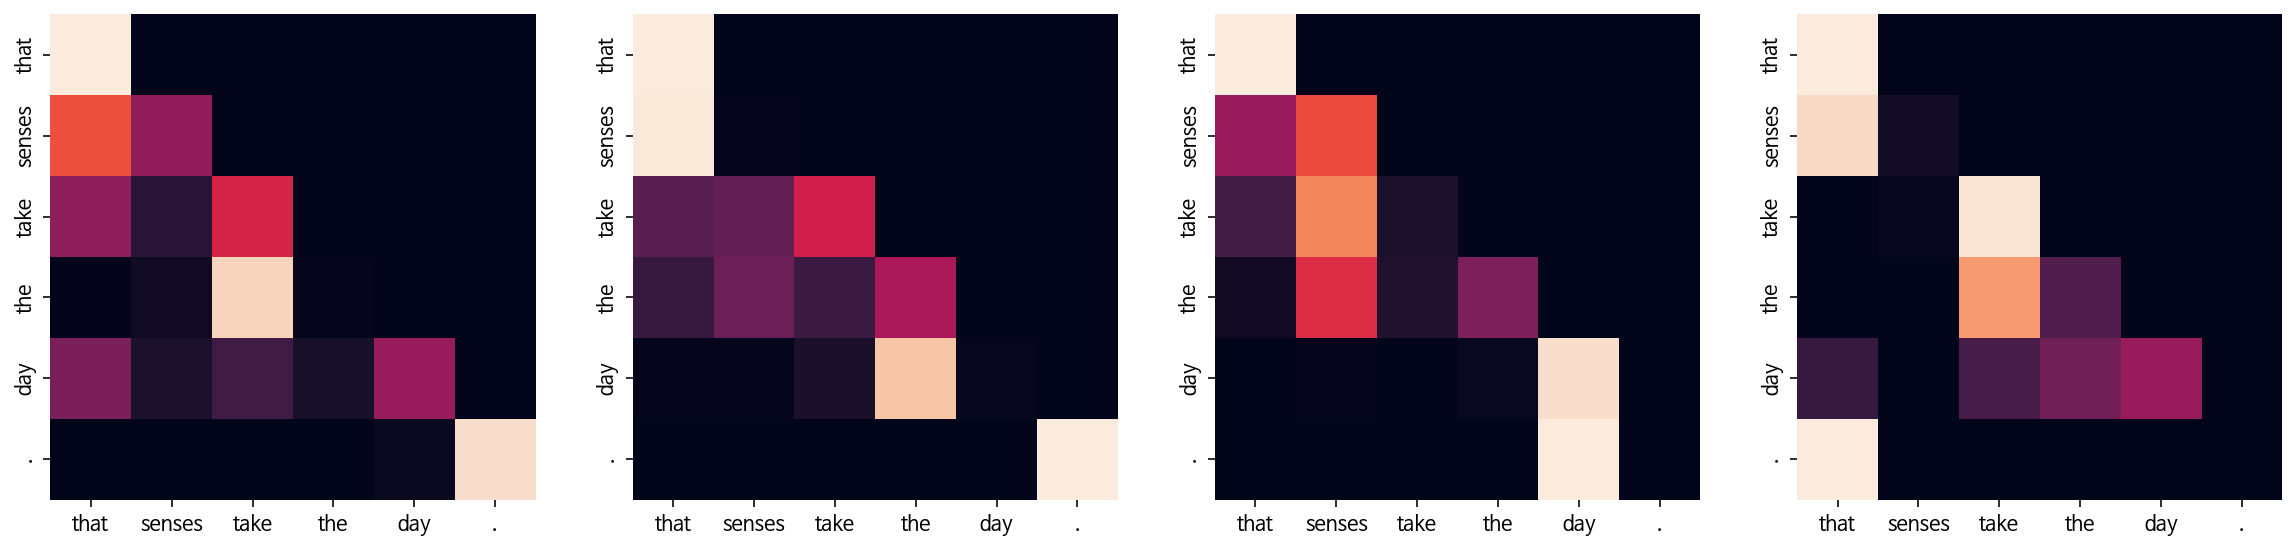

Decoder Src Layer 2


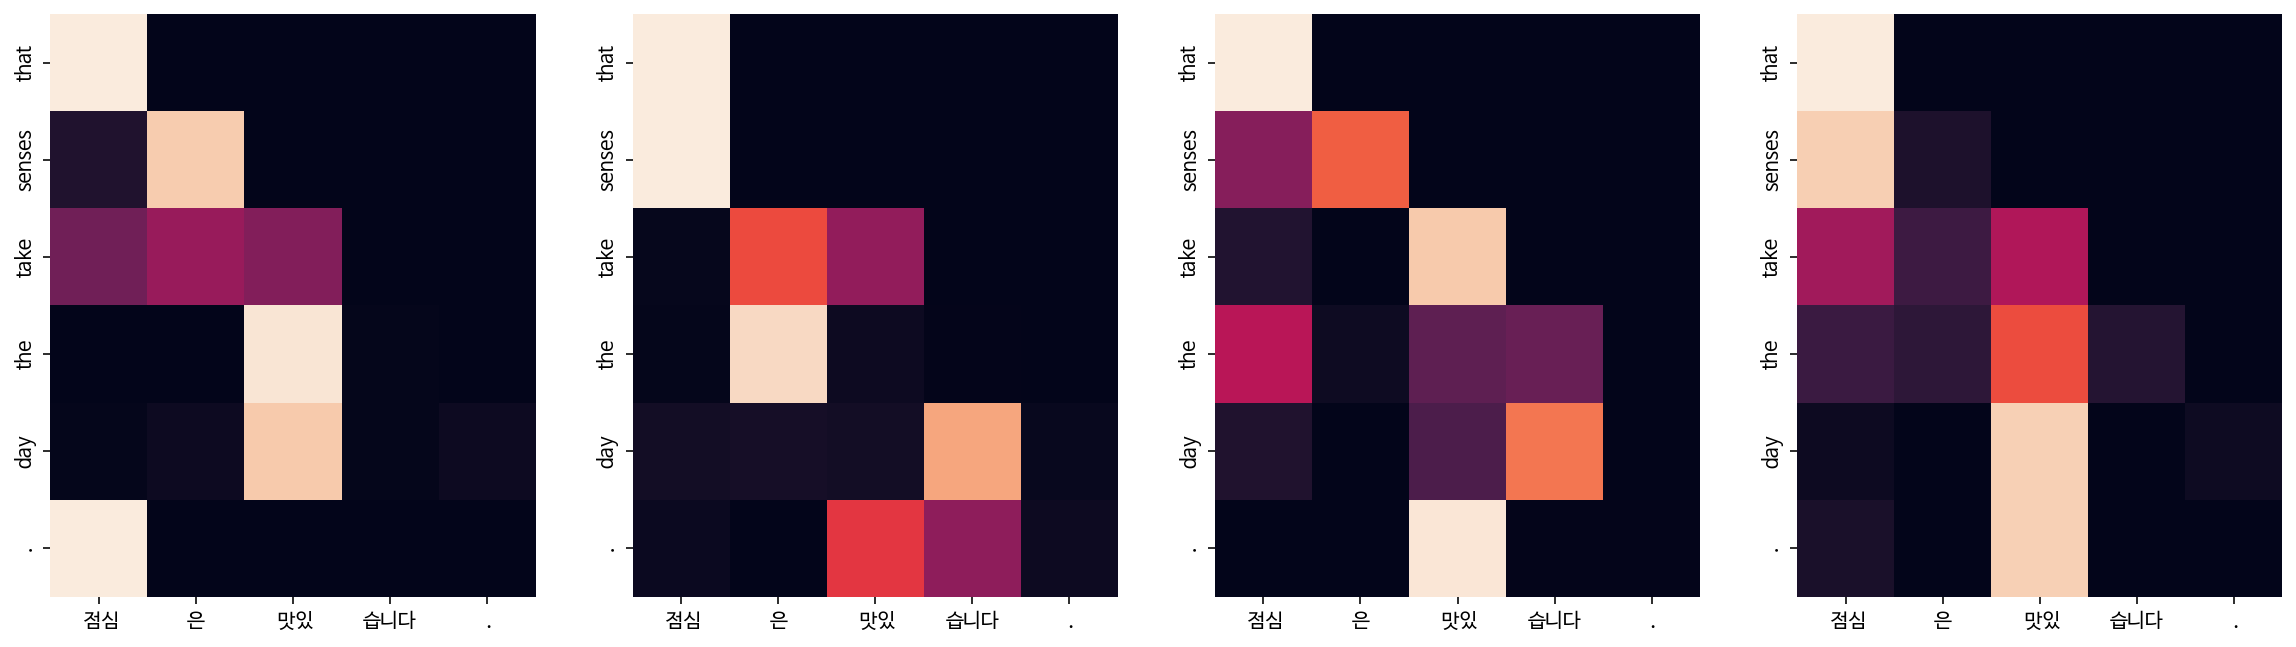

In [28]:
translate("점심은 맛있습니다.", transformer, ko_tokenizer, en_tokenizer,True)

Input: 머리 아프다.
Predicted translation: his head has acted as a normal hair things down .
Encoder Layer 1


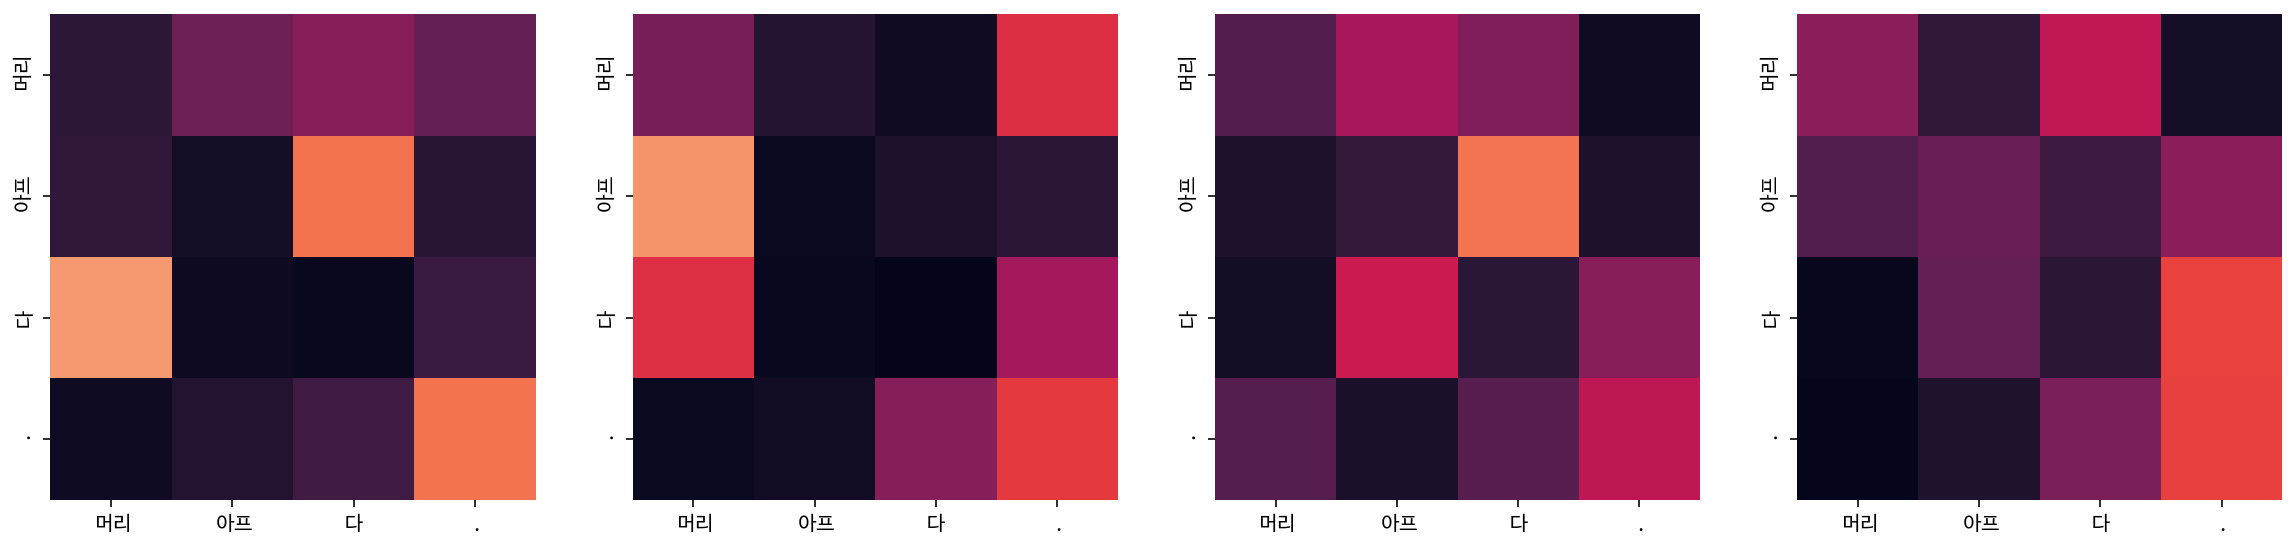

Encoder Layer 2


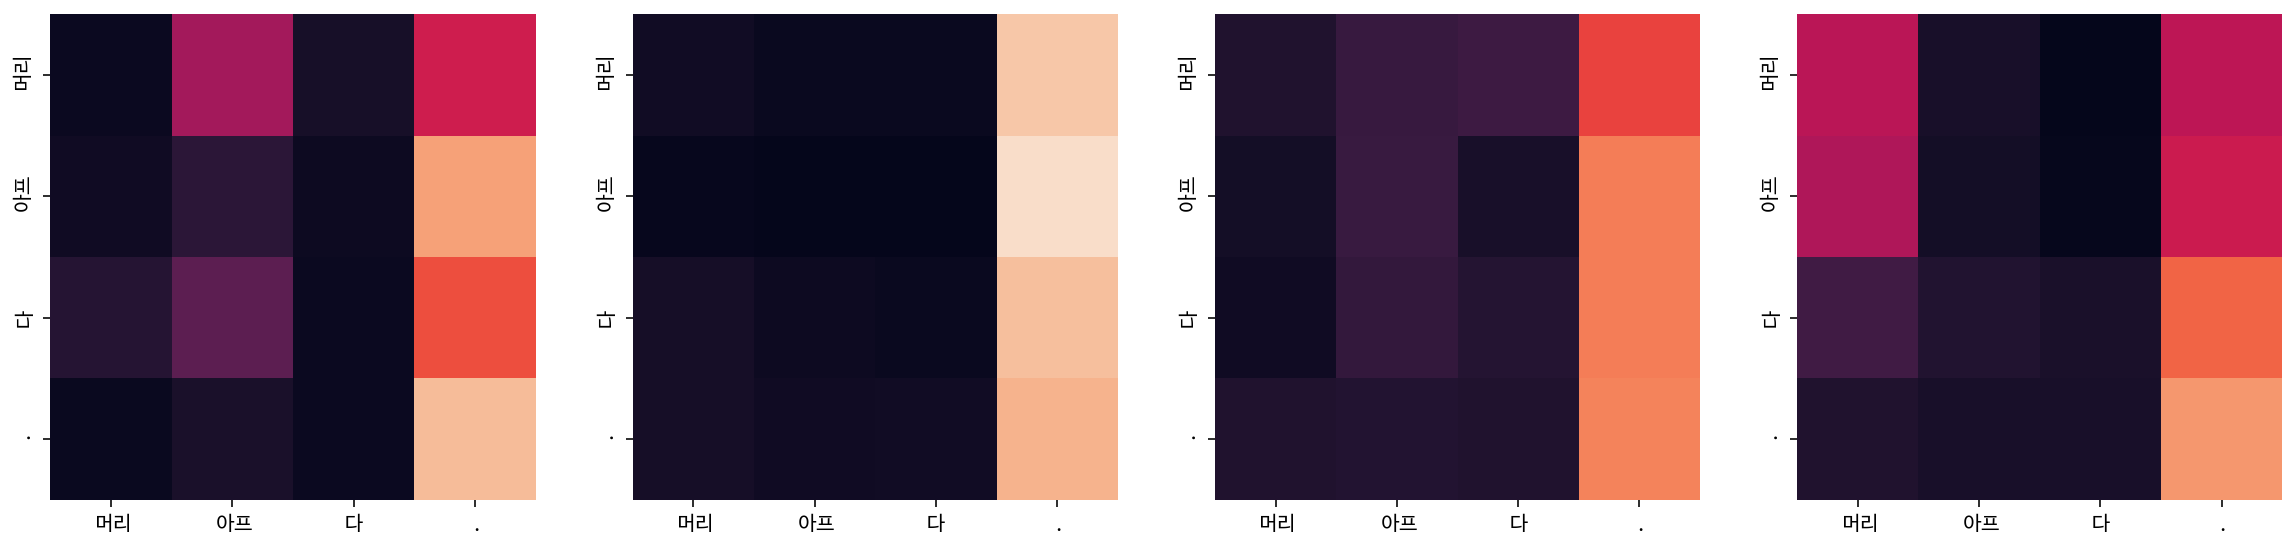

Decoder Self Layer 1


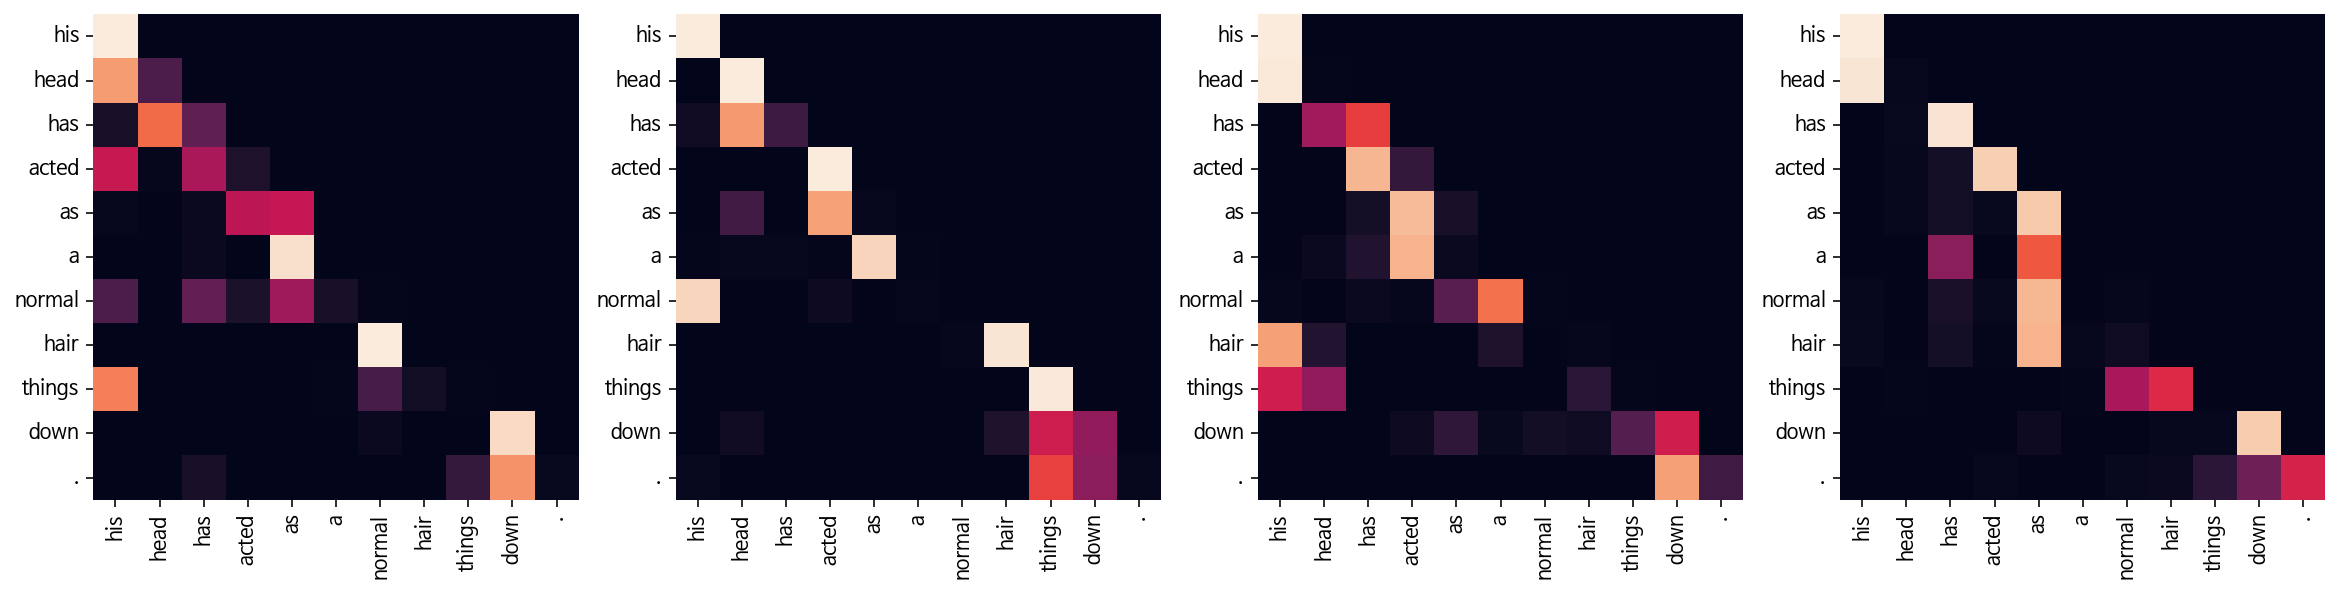

Decoder Src Layer 1


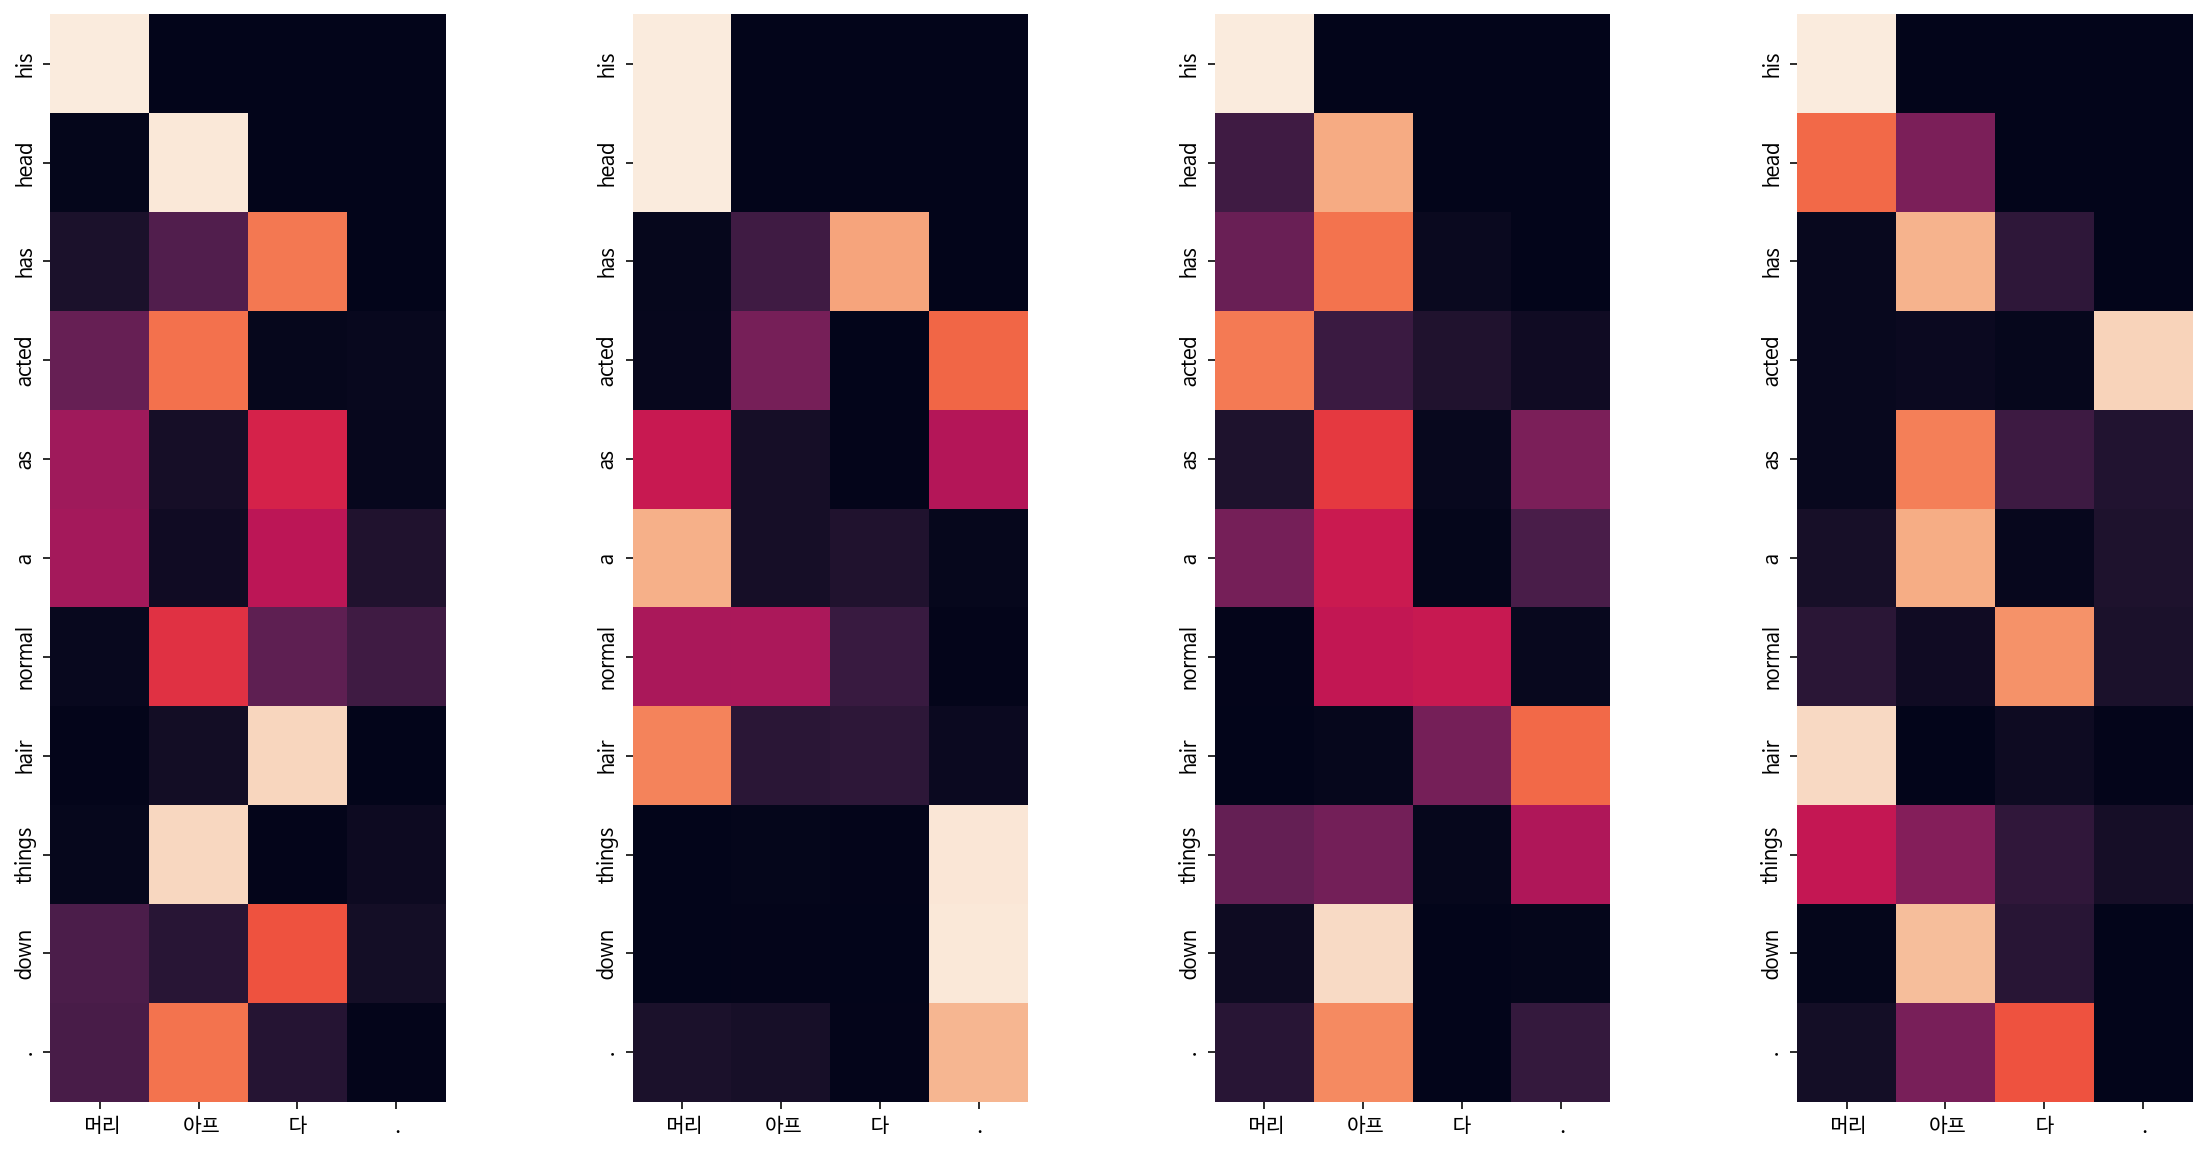

Decoder Self Layer 2


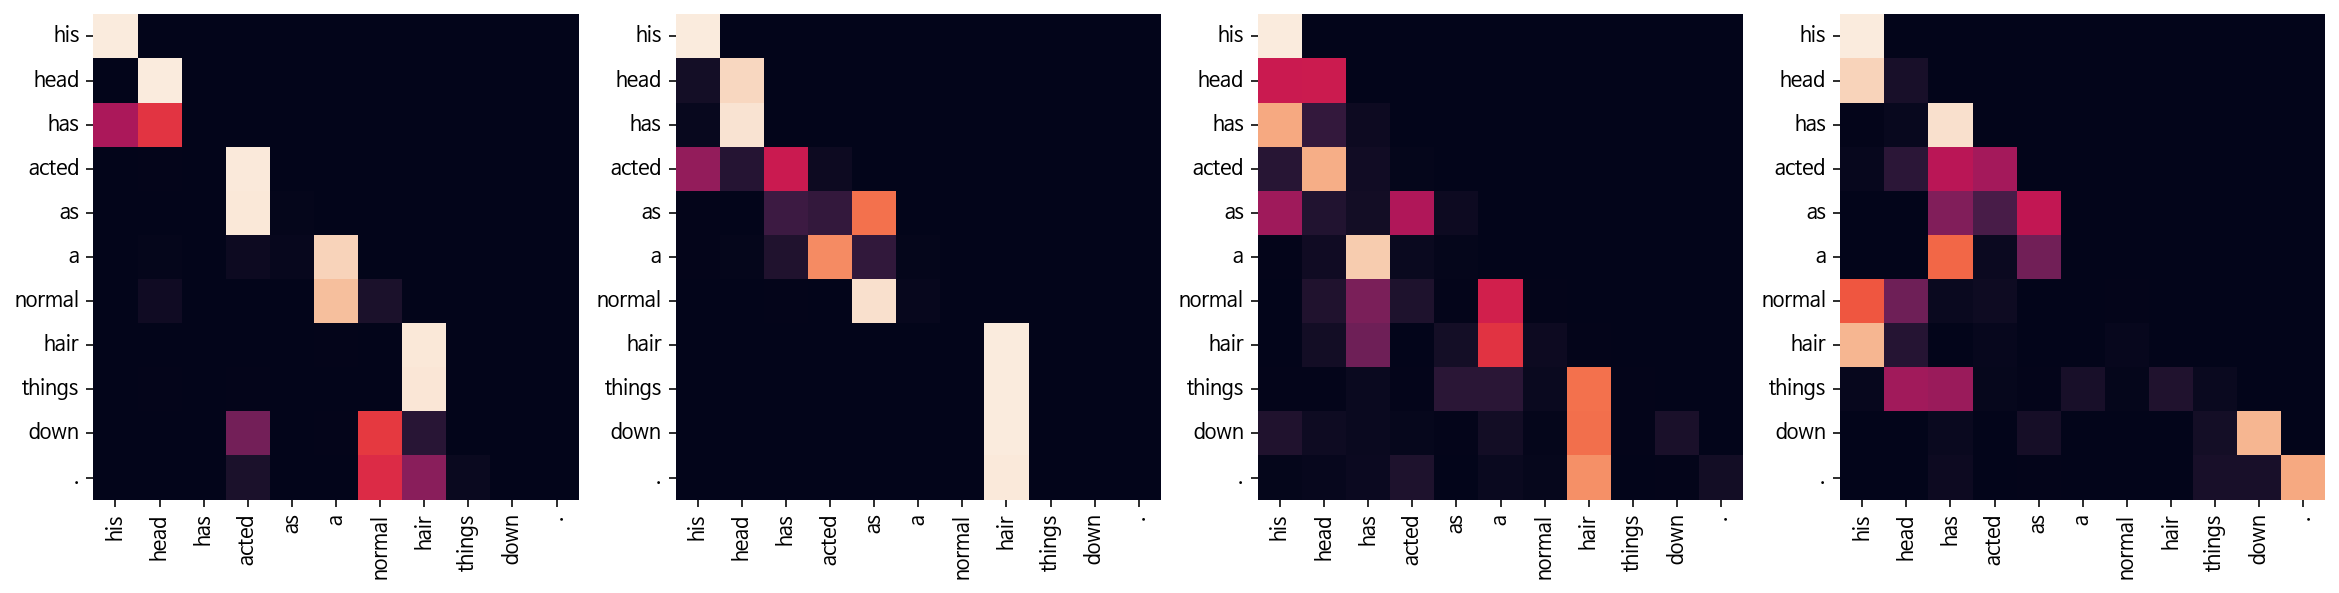

Decoder Src Layer 2


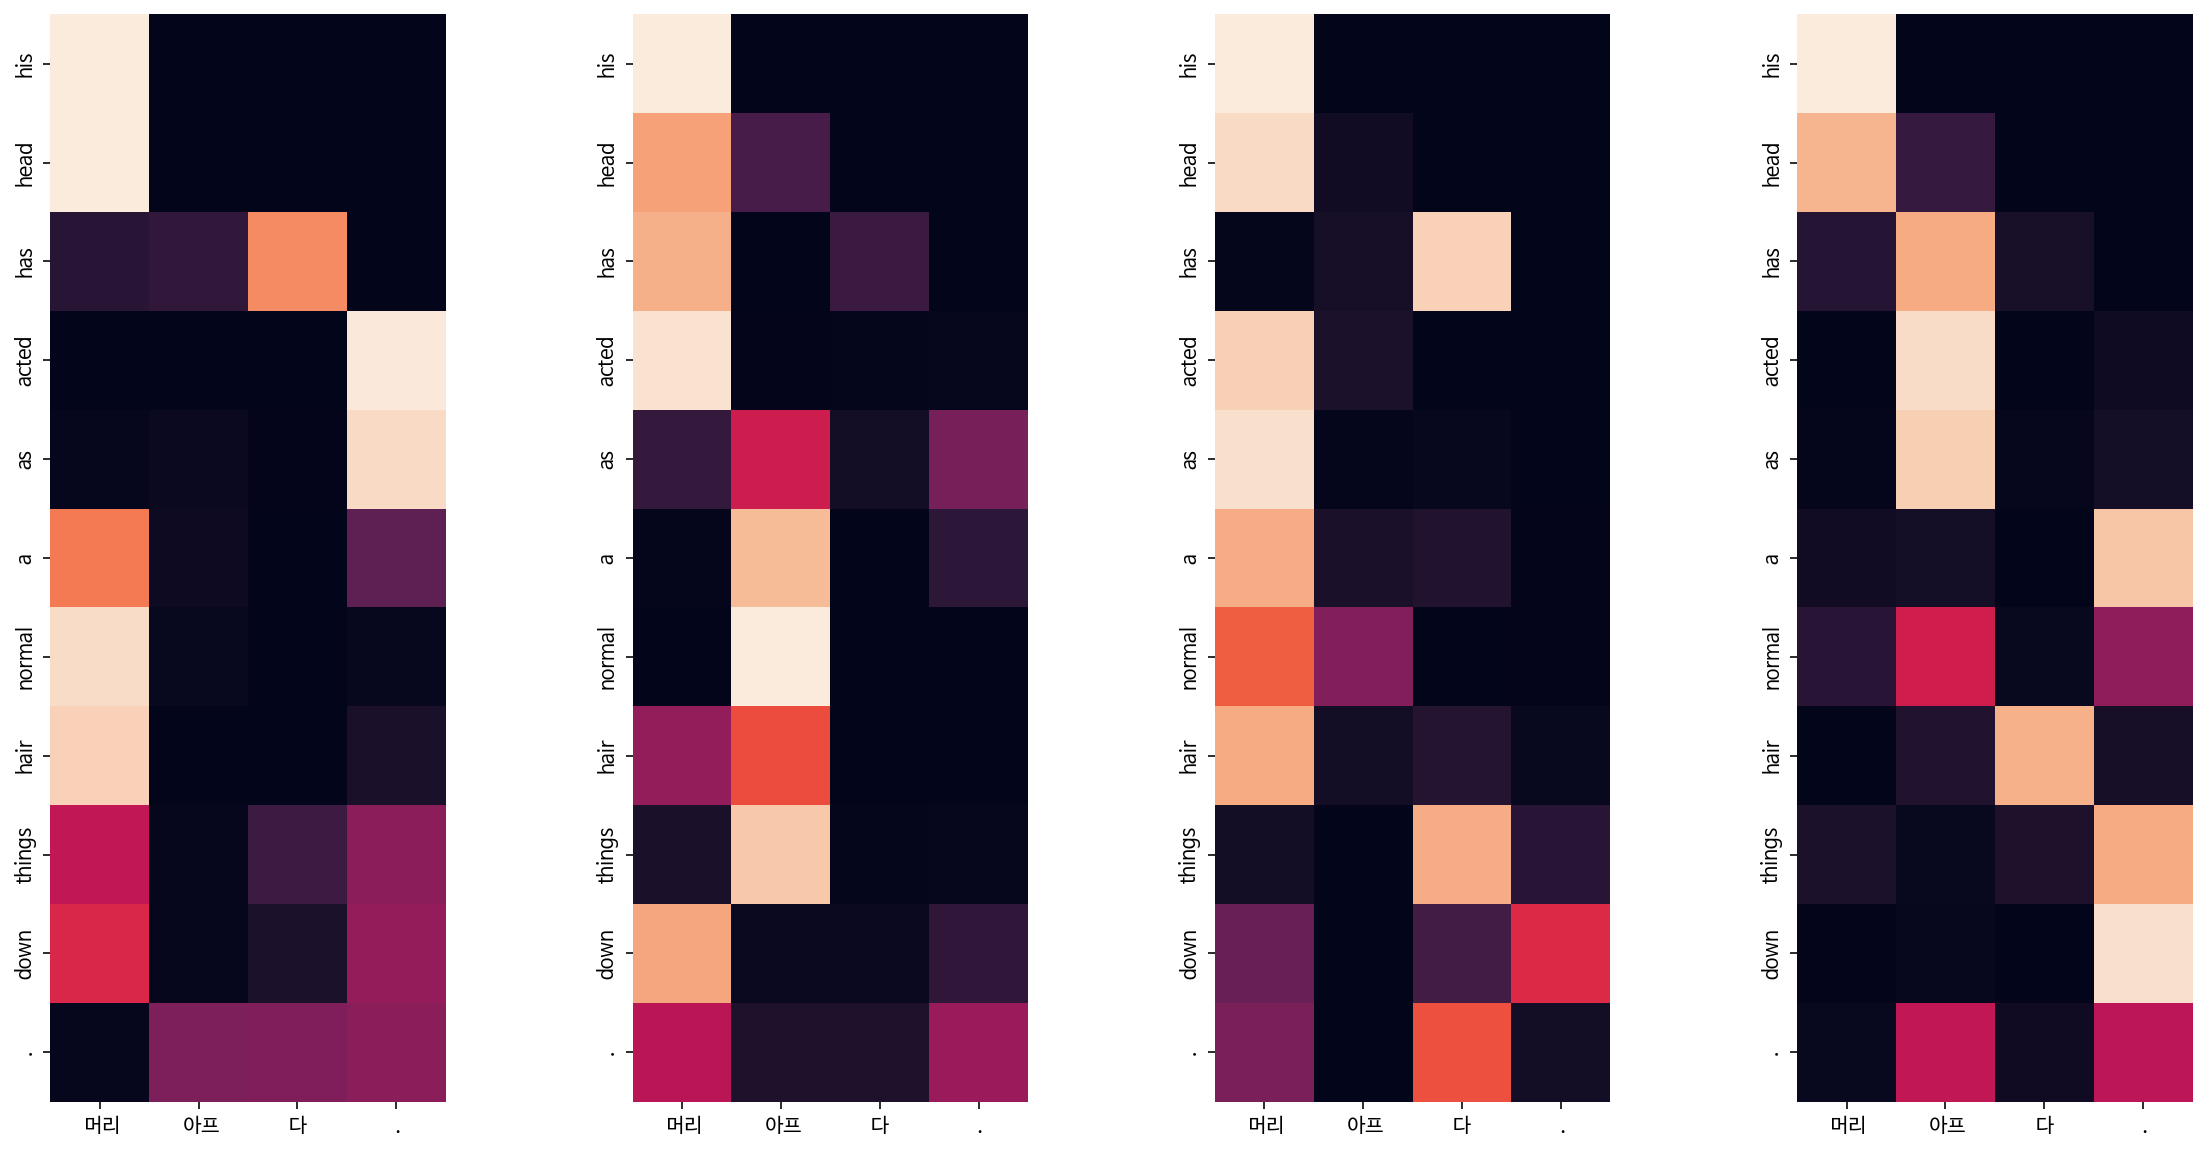

In [30]:
translate("머리 아프다.", transformer, ko_tokenizer, en_tokenizer,True)

Input: 영화 보러가자
Predicted translation: wall street
Encoder Layer 1


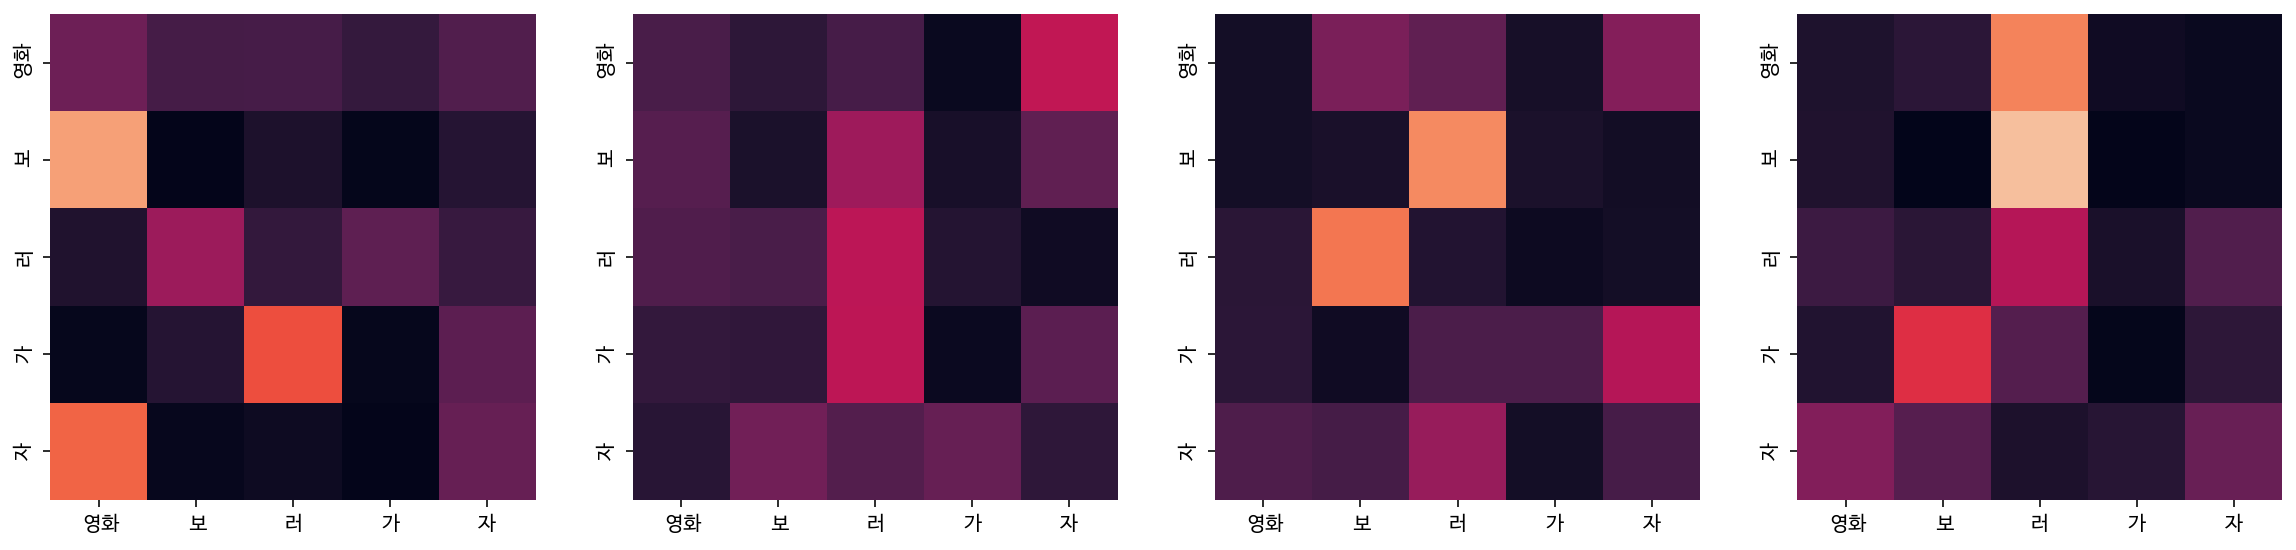

Encoder Layer 2


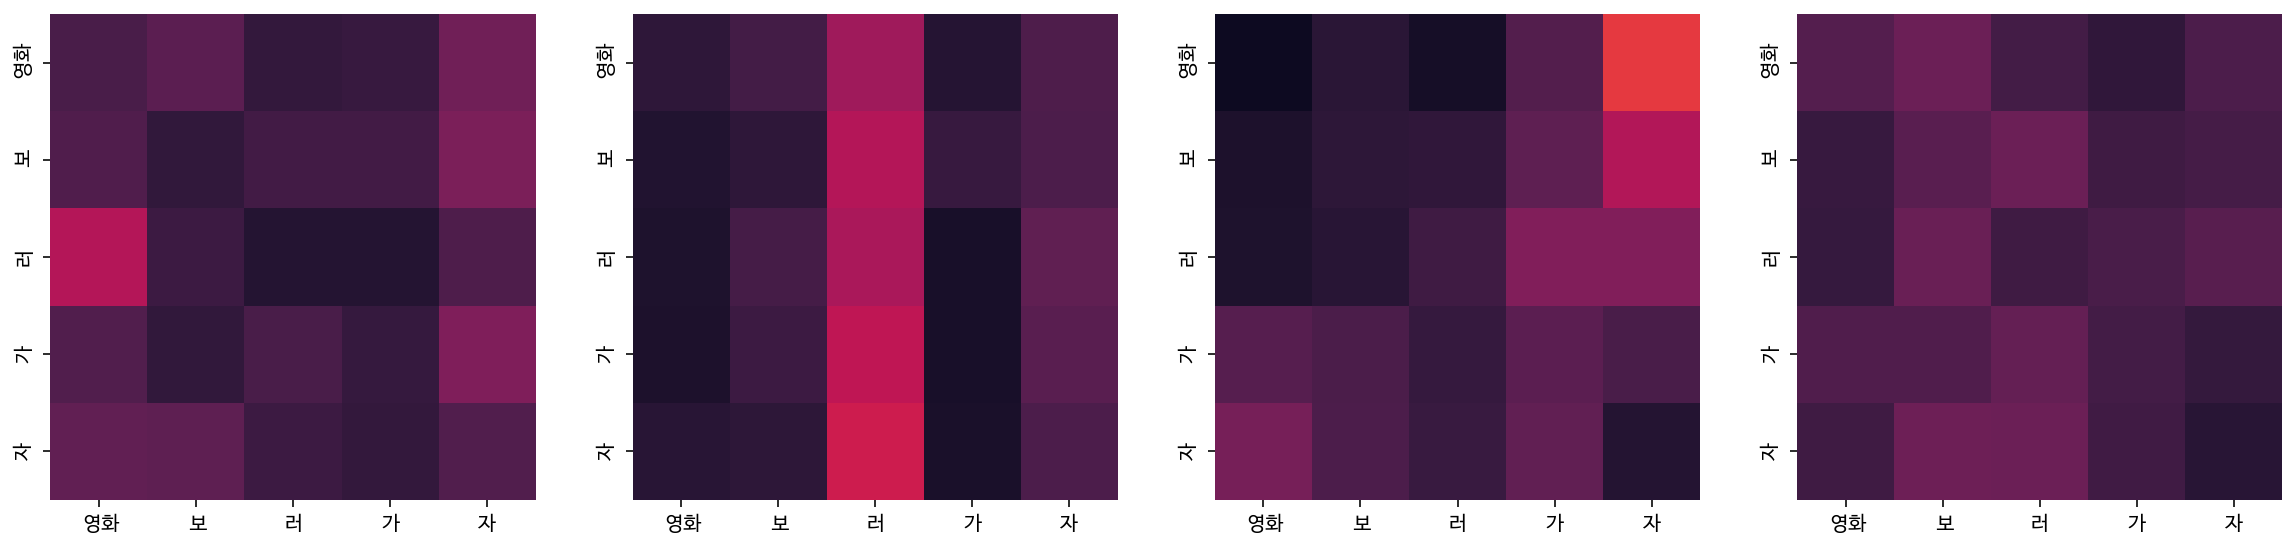

Decoder Self Layer 1


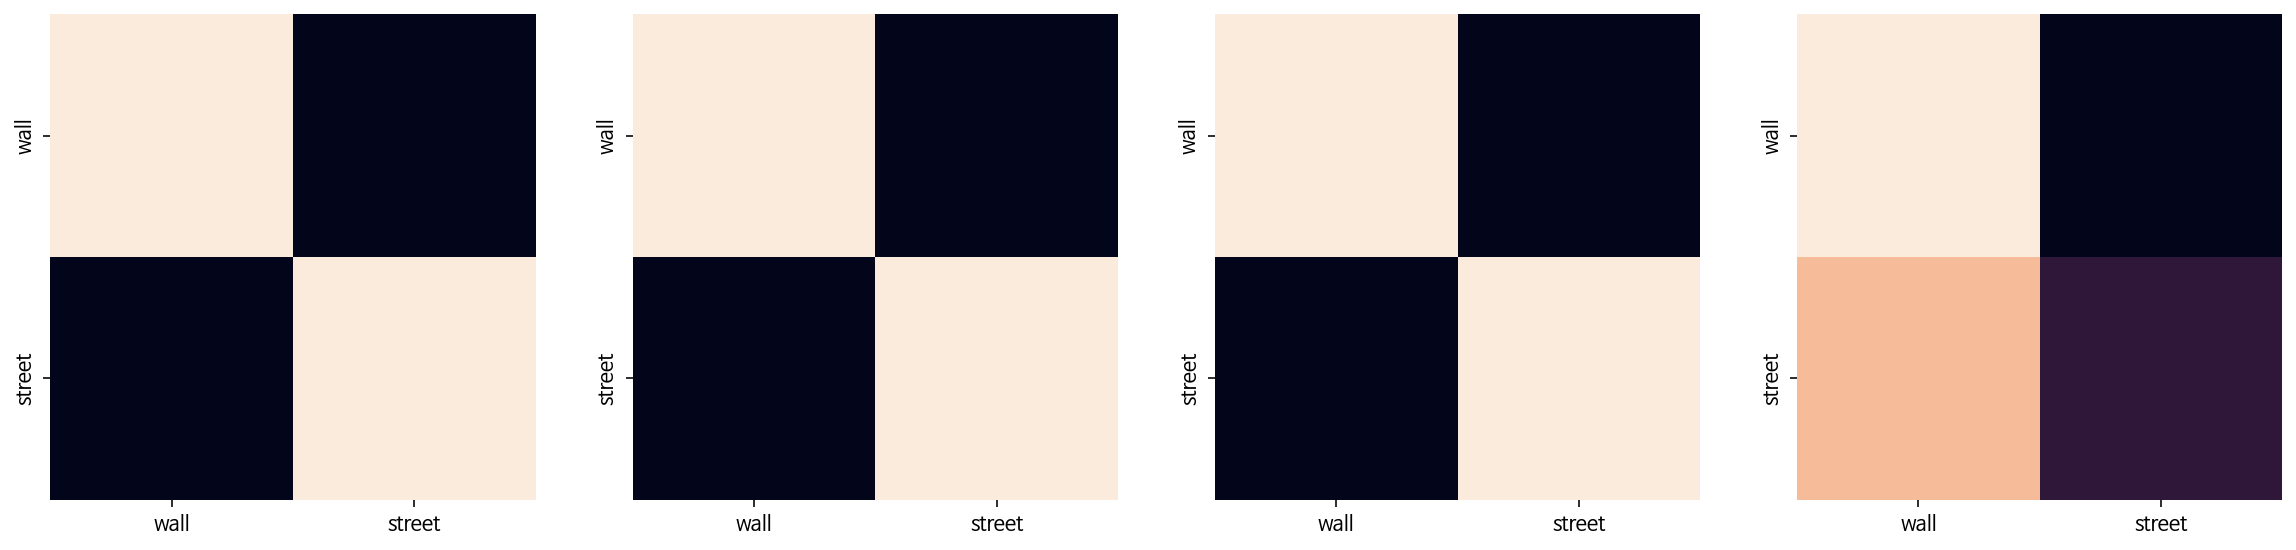

Decoder Src Layer 1


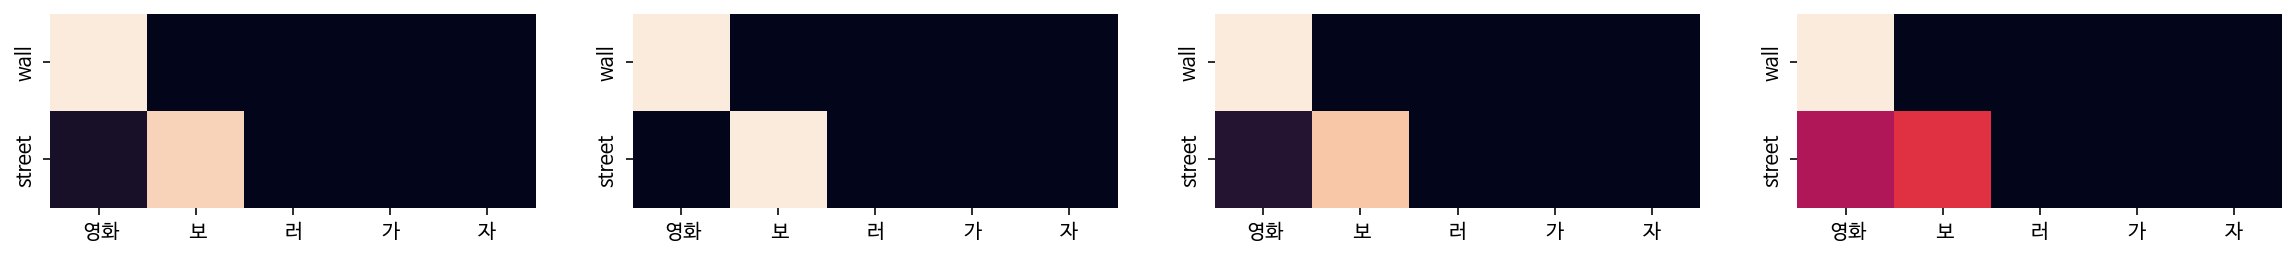

Decoder Self Layer 2


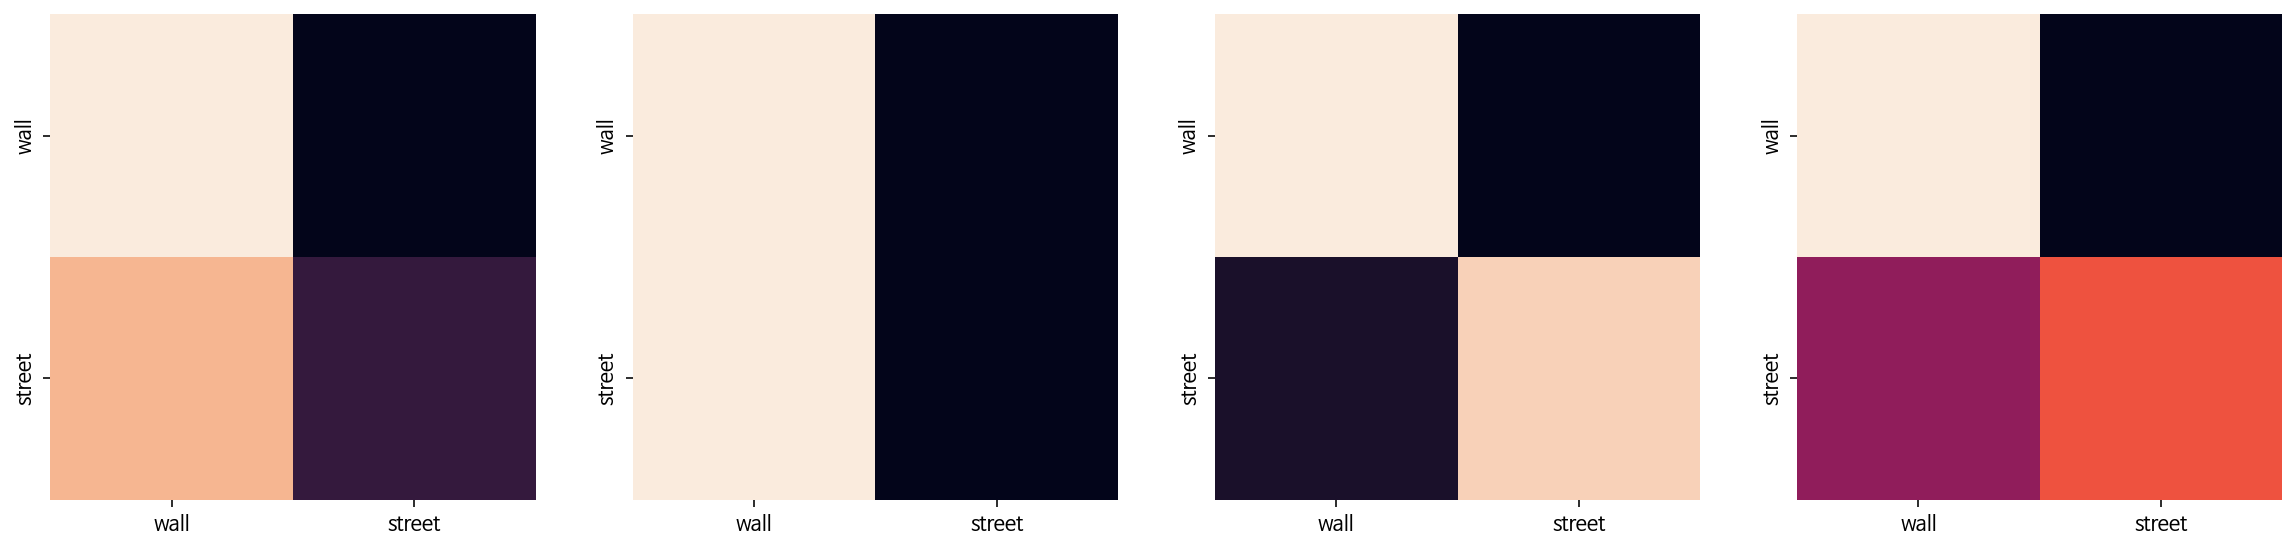

Decoder Src Layer 2


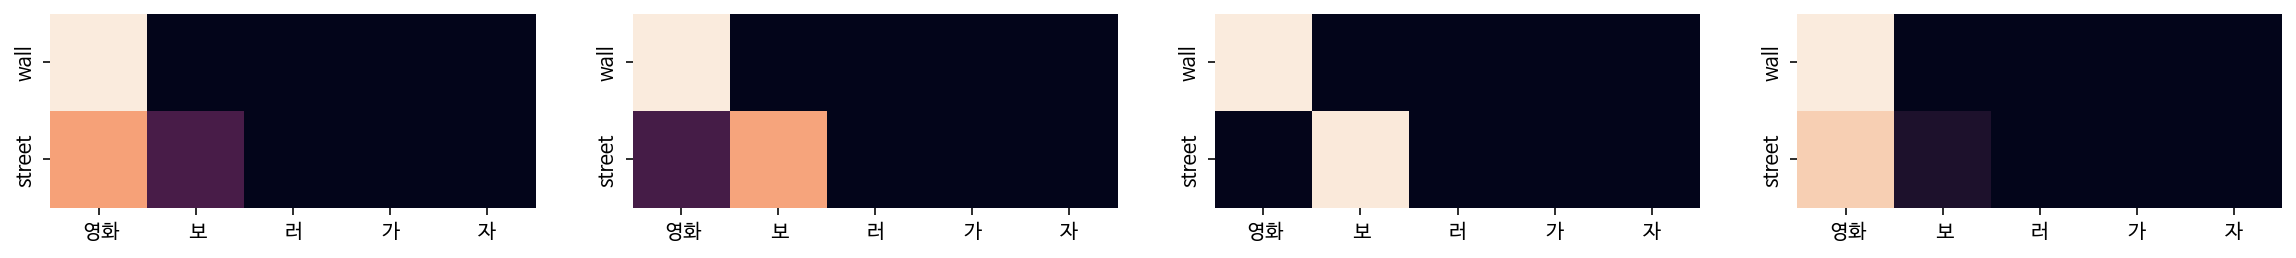

In [31]:
translate("영화 보러가자", transformer, ko_tokenizer, en_tokenizer,True)

Input: 또 이것이 포지셔널 인코딩이 충족시켜야 하는 4가지 조건을 어떻게 충족시킬수 있는지 이야기해보자.
Predicted translation: and it would be a good incentive who works in four years to meet the property should be hosting a by condition or discussion , according to the web site .
Encoder Layer 1


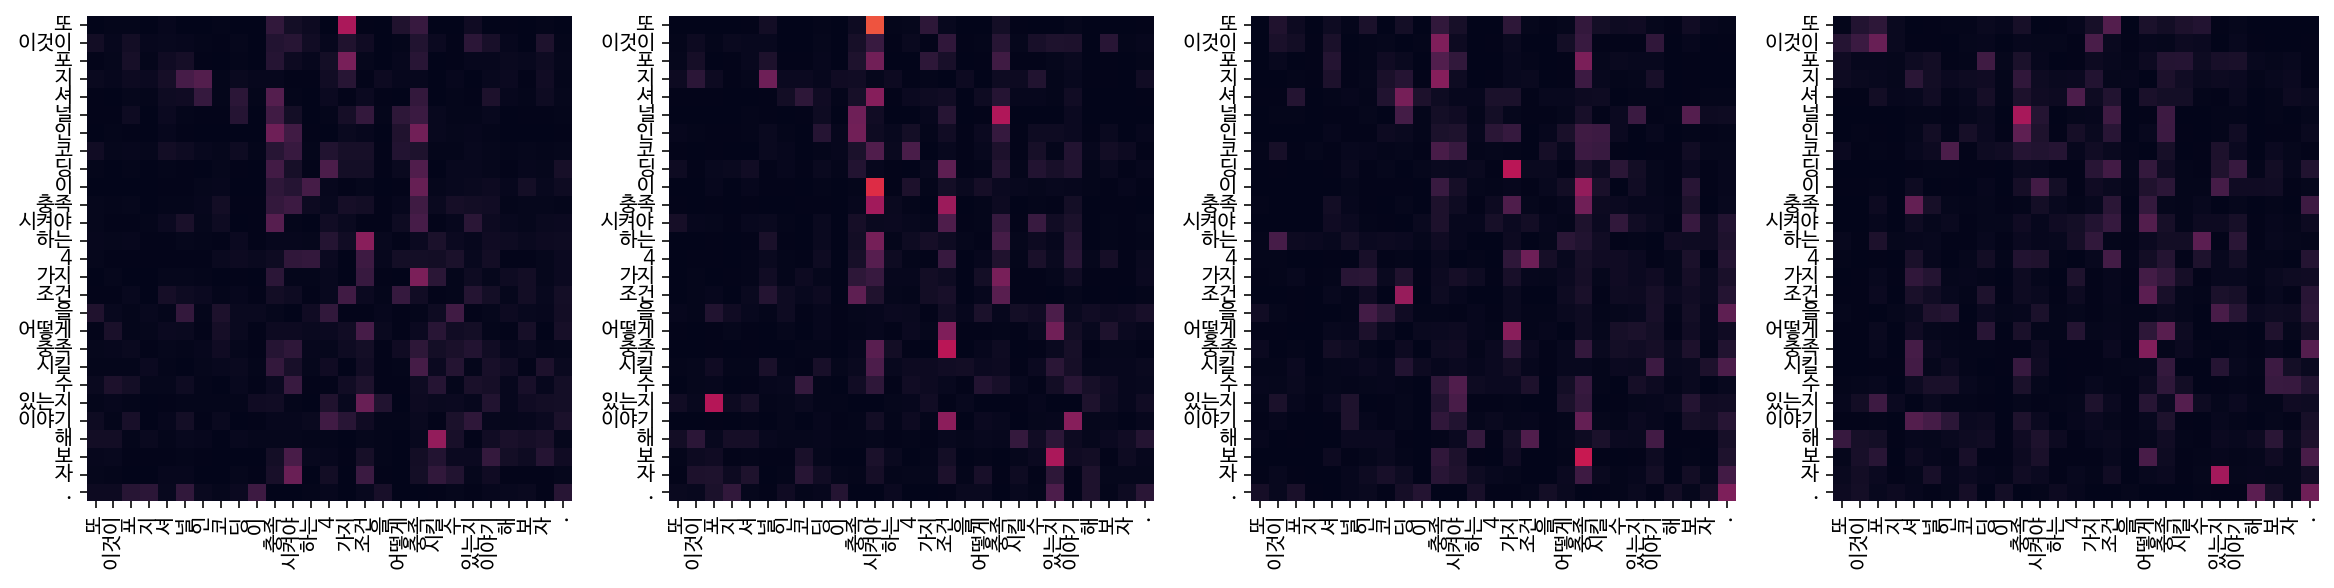

Encoder Layer 2


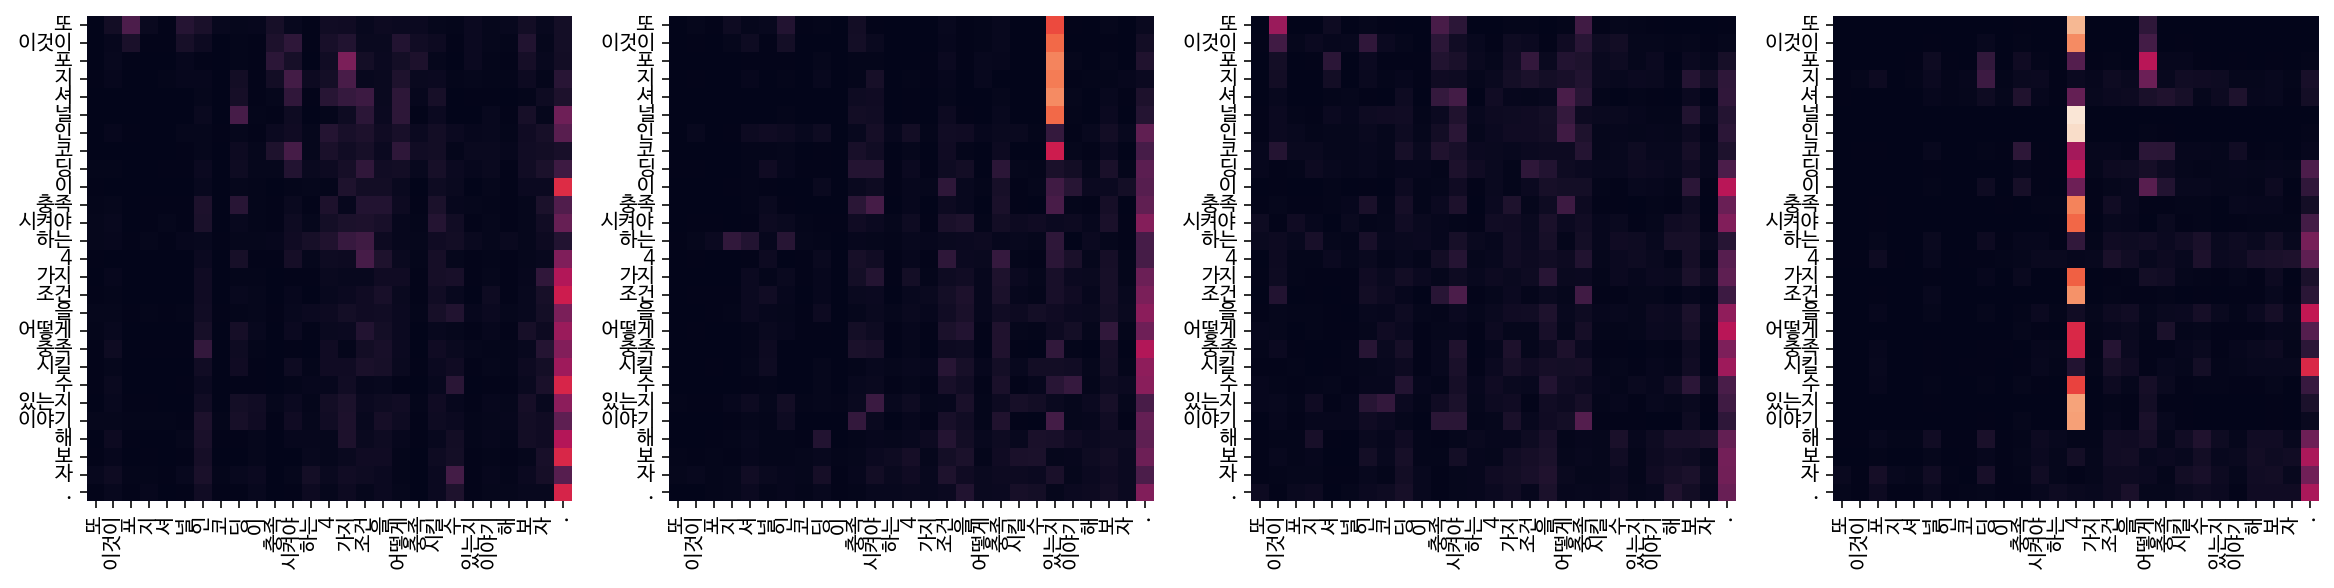

Decoder Self Layer 1


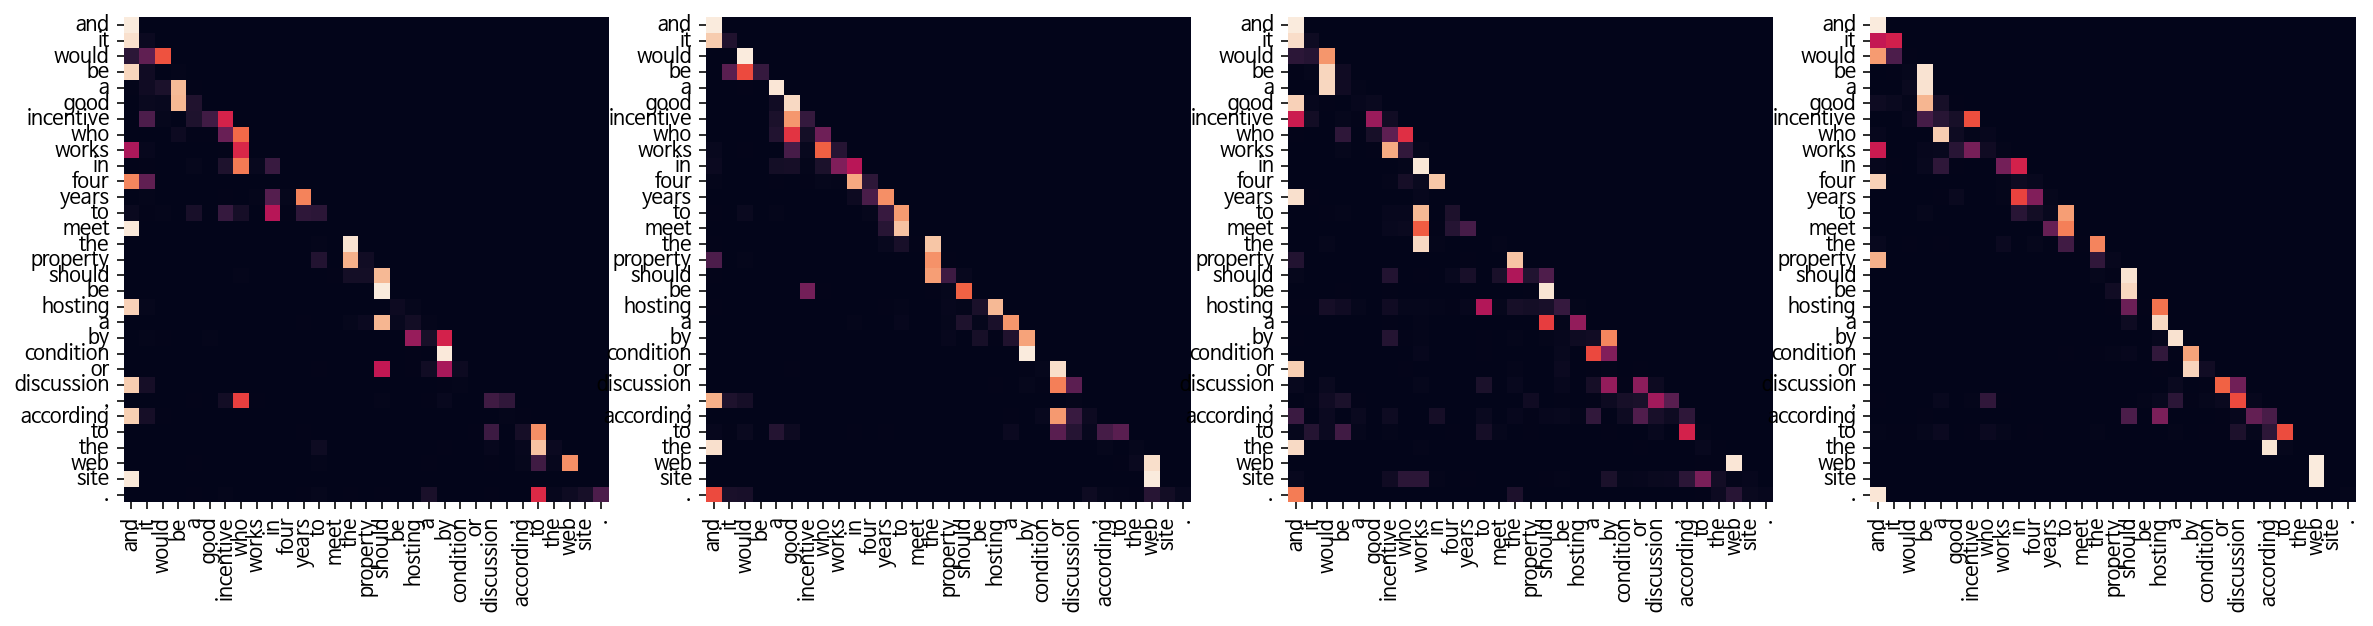

Decoder Src Layer 1


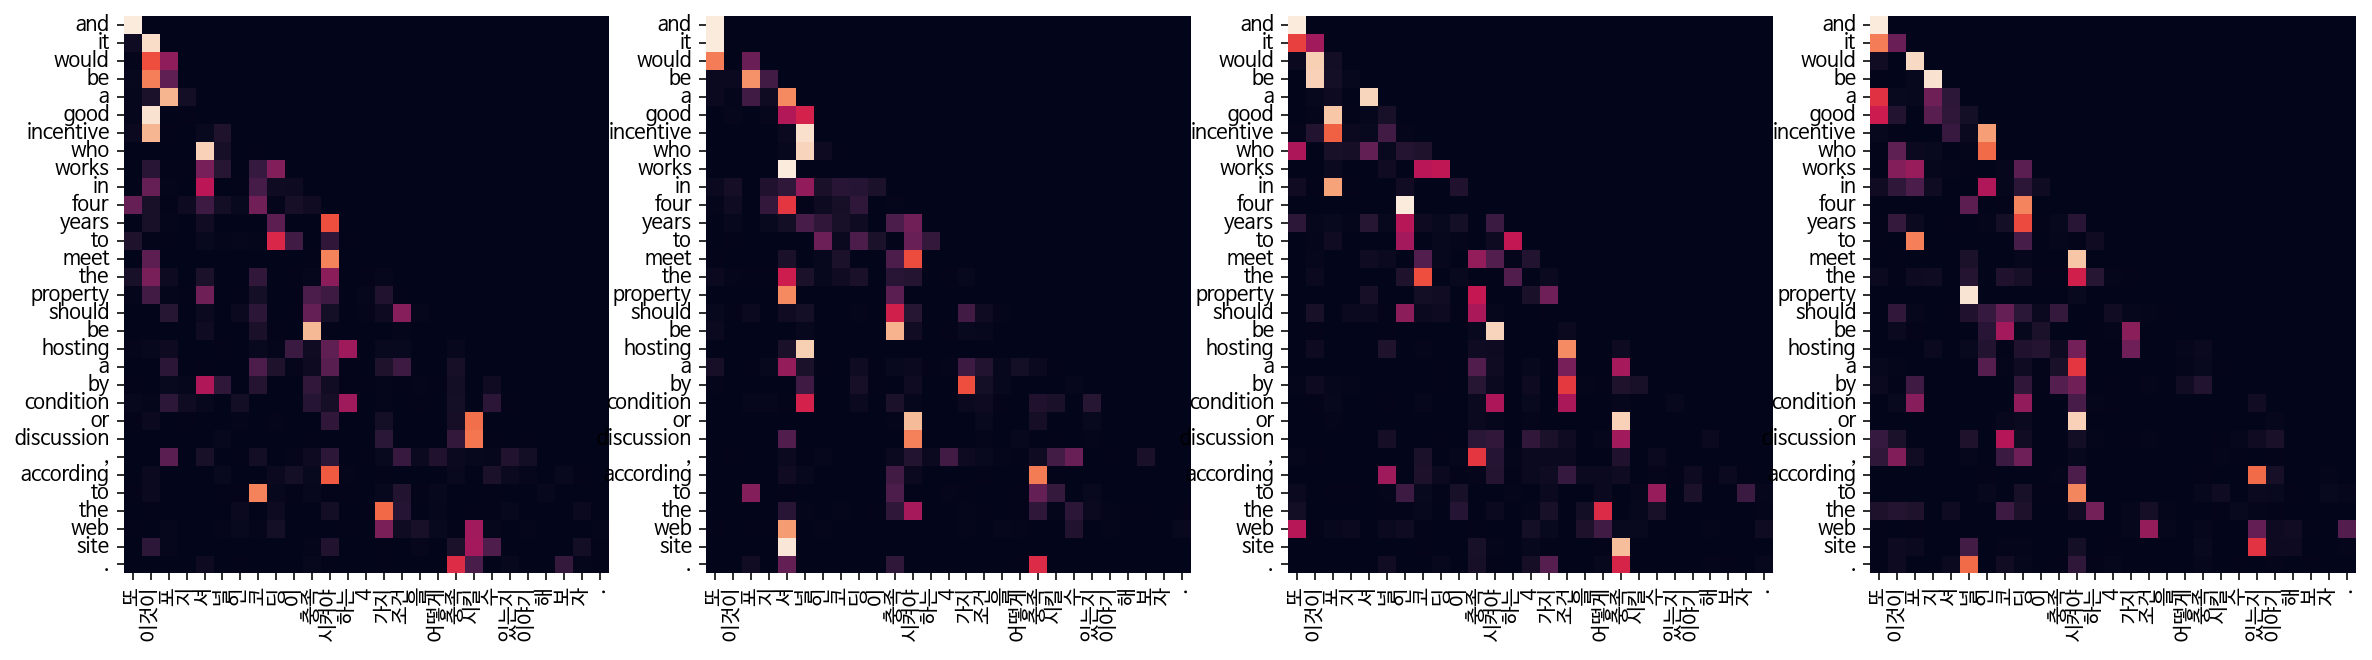

Decoder Self Layer 2


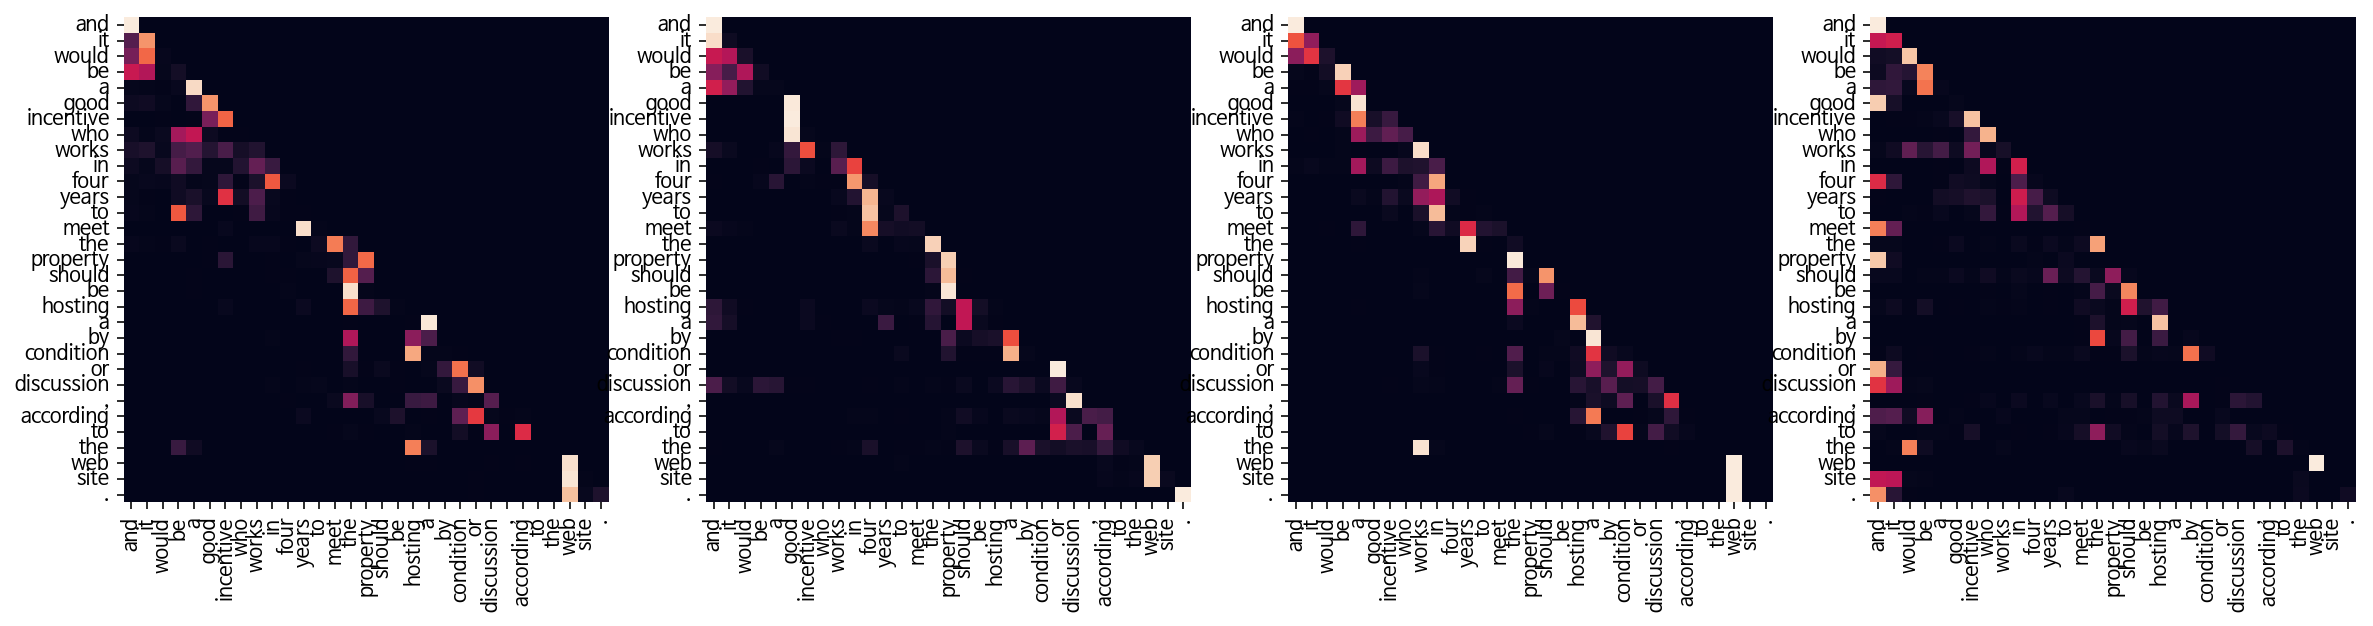

Decoder Src Layer 2


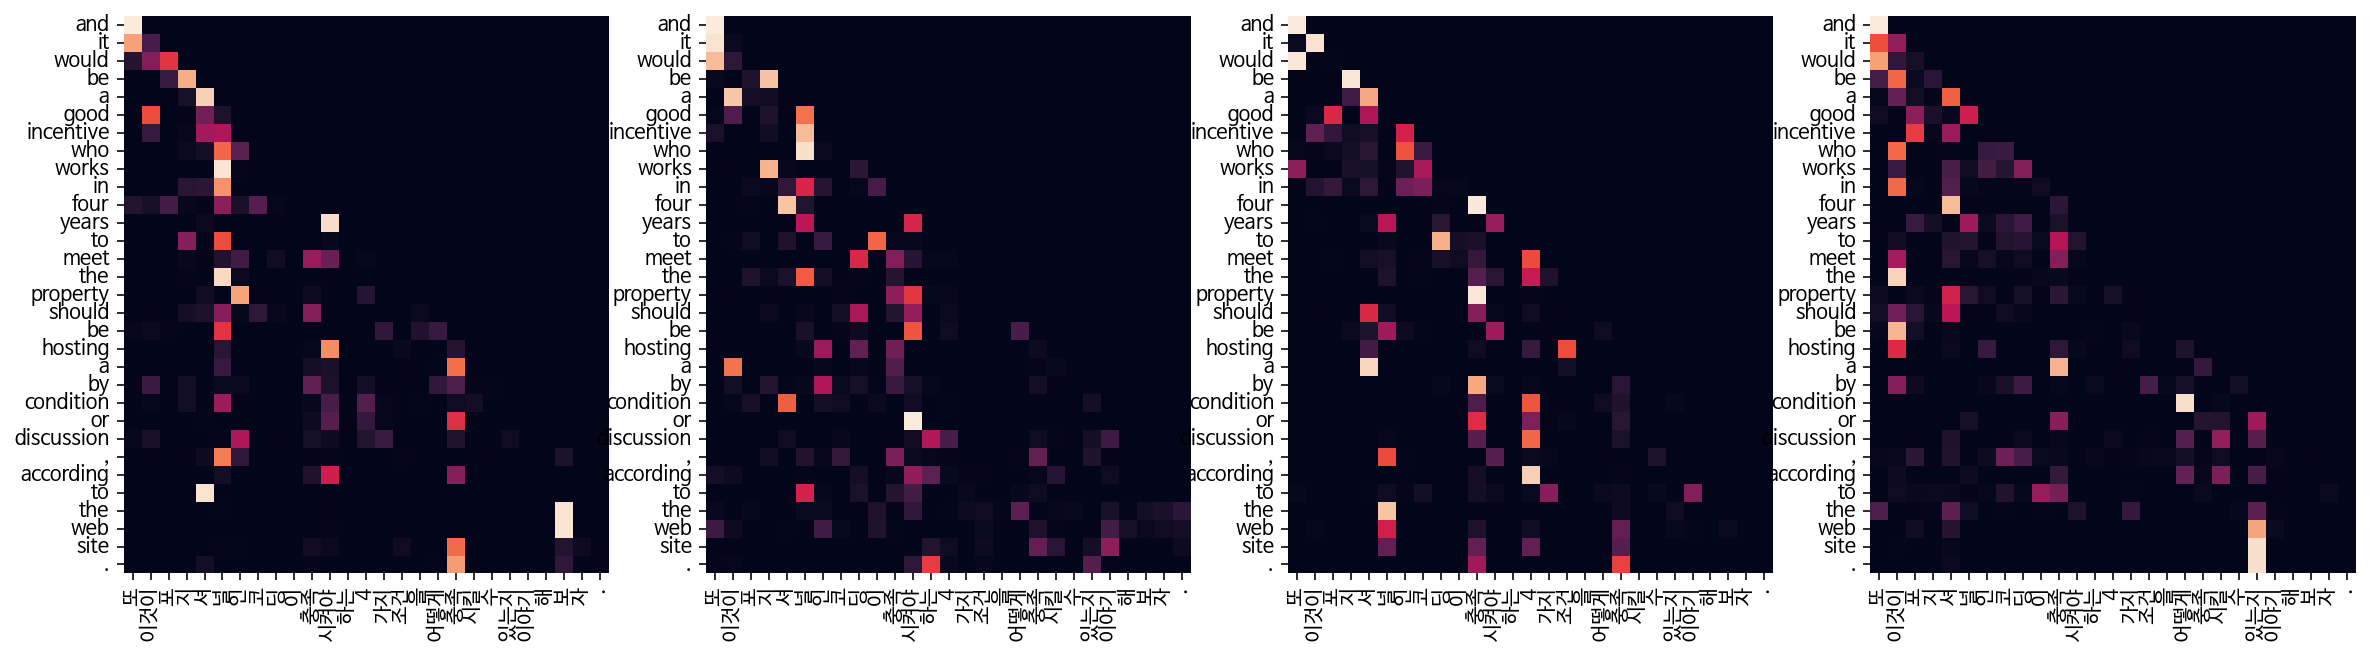

In [32]:
translate("또 이것이 포지셔널 인코딩이 충족시켜야 하는 4가지 조건을 어떻게 충족시킬수 있는지 이야기해보자.", transformer, ko_tokenizer, en_tokenizer,True)